In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pybaselines import Baseline, utils
import shutil
import re
from sklearn import preprocessing as pre
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
import csv
from scipy.signal import savgol_filter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_val_score


import scipy.stats as stats
import cv2

import tensorflow as tf
from tensorflow import keras
import seaborn as sns


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Remove the folder from ./name to ./empty folder 
# Remove the folder of ./old spandex to ./old spandex/empty
path = "./Final_Database/"
db = os.listdir(path)
for i in range(len(db)):
    folder = os.listdir(path+db[i])
    if len(folder) == 0 and db[i]!='empty':
        org = path+db[i]
        new = path+'empty/'
        shutil.move(org, new)

In [6]:
path = './Final_Database/'
db = os.listdir(path)
#db.remove('empty')
#db.remove('new spandex')
#db.remove('old spandex')

In [7]:
path = "./Final_Database/"
db = os.listdir(path)
c = []
for i in range(len(db)):
    files = os.listdir(path+db[i])
    for j in range(len(files)):
#        print(files[j])
        c_tmp = re.split(' ',files[j])[0].split("_")[1]
        c.append(c_tmp)

In [8]:
len(c)

1917

In [10]:
hist = pd.array(c).value_counts()
pd.array(c).value_counts()[:20]

C100      466
P100      220
P86S14    186
P40C60    156
rP100     127
P95S5      44
S4C96      40
P96S4      33
P90S10     31
P92S8      31
P93S7      28
P99C1      26
N100       26
P85C15     22
P88S12     21
P91S9      18
P58C42     16
P87S13     16
S10N90     15
P94S6      14
dtype: Int64

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, 

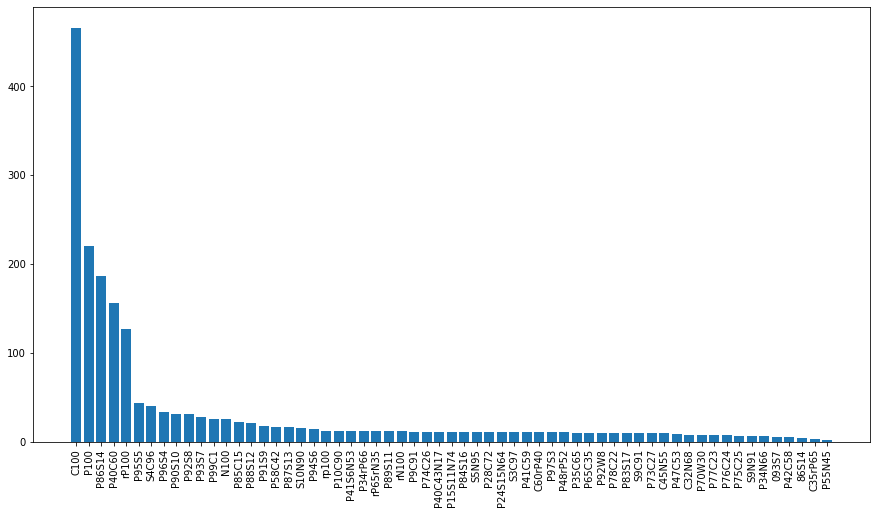

In [11]:
hist = pd.DataFrame(hist)
hist.rename(columns={0:"count"},inplace=True)

plt.figure(figsize=(15,8))
plt.bar(list(hist.index),hist['count'])
plt.xticks(rotation=90)

In [12]:
def file_read_norm(data_path):
    spectrum = pd.read_csv(data_path).iloc[3:,:]
    spectrum_array = np.array(spectrum.iloc[140:-30])
     
    wavelength = np.array(spectrum.iloc[140:-30]['IntTime(ms)']).astype("float32")
    intensity = np.array(spectrum.iloc[140:-30]['1000.000']).astype("float32")
    #plt.plot(wavelength,intensity)

    baseline_fitter = Baseline(x_data=wavelength)
    bkg= baseline_fitter.iarpls(intensity, lam=10000.0, diff_order=4, max_iter=50, tol=0.001)[0]
    #plt.plot(wavelength,bkg)

    #plt.plot(wavelength,intensity-bkg)
    #plt.show()

    normed = pre.MinMaxScaler().fit_transform((intensity-bkg).reshape(-1, 1))
    #plt.plot(wavelength,normed)
    #plt.show()

    data = normed.reshape(-1)

    w = 9
    p = 2 

    smoothed_spectrum = savgol_filter(data, w, polyorder= p, deriv=0)

    #plt.plot(wavelength,smoothed_spectrum)
    #plt.show()
    
    return smoothed_spectrum

In [346]:
def comma_format(x, pos):
    if abs(x) >= 10000:  # Only format if the number is 10,000 or greater
        return f'{int(x):,}'
    else:
        return f'{int(x)}'  # Just return the number as is if it's less than 10,000

(342,)


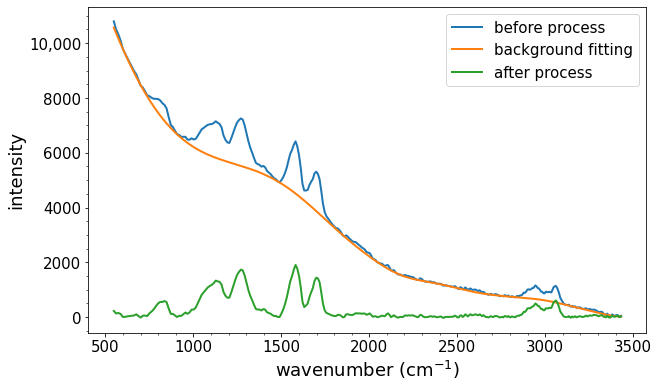

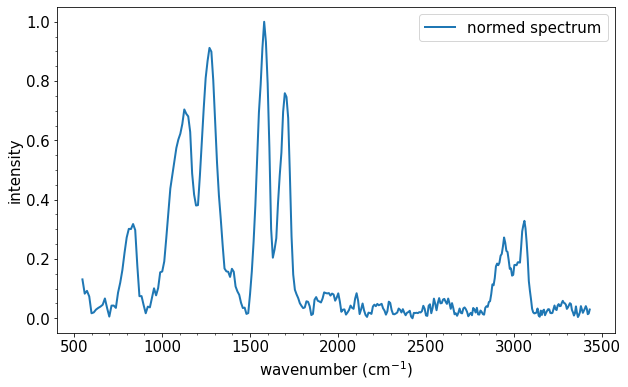

In [347]:
outlier = pd.read_csv("../L133.csv").iloc[3:,:]
outlier = outlier.rename(columns = {"IntTime(ms)":"wavenumber","1000.000":"intensity"})
outlier.reset_index(inplace=True)
outlier = outlier.drop(['index'],axis=1)


x = np.array(outlier['wavenumber'])[140:-30].astype("float32")
wavenumber = x
print(wavenumber.shape)
y = np.array(outlier['intensity'])[140:-30].astype("float32")
plt.rcParams.update({'font.size':15})
plt.figure(figsize=(10,6))
plt.plot(x,y,label="before process",linewidth=2)
plt.legend()

baseline_fitter = Baseline(x_data=x)
bkg= baseline_fitter.iarpls(y, lam=10000.0, diff_order=3, max_iter=50, tol=0.001)[0]
plt.plot(x,bkg,label="background fitting",linewidth=2)
plt.xlabel("wavenumber (cm-1)",fontsize=18)
plt.ylabel("intensity", fontsize=18)
plt.minorticks_on()

plt.plot(x,y-bkg,label='after process',linewidth=2)
plt.legend()
plt.xlabel("wavenumber (cm$^{-1}$)")
plt.ylabel("intensity")
plt.minorticks_on()
plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_format))
plt.show()


normed = pre.MinMaxScaler().fit_transform((y-bkg).reshape(-1, 1))
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size':15})
plt.xlabel("wavenumber (cm$^{−1}$)") #$^{n+1}$
plt.plot(x,normed,label='normed spectrum',linewidth=2)
plt.legend()
plt.ylabel("intensity")
plt.minorticks_on()
plt.show()


In [337]:
from matplotlib.ticker import FuncFormatter

In [184]:
X.index

RangeIndex(start=0, stop=1753, step=1)

(342,)


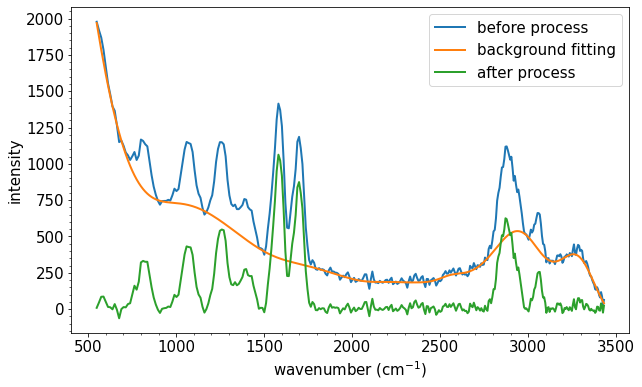

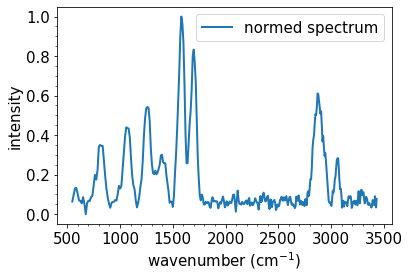

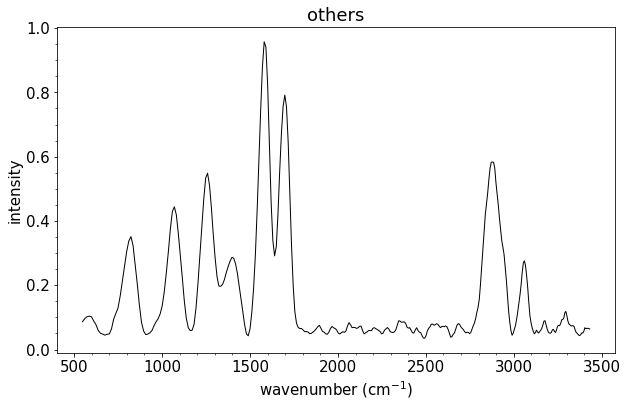

(342,)


In [348]:
from matplotlib.ticker import FuncFormatter

folders = os.listdir("./Final_Database/")
name = "6_SK(11)"
files = os.listdir("./Final_Database/"+name)
C100 = pd.read_csv("./Final_Database/"+name+"/"+files[1]).iloc[3:,:]
#C100 = pd.read_csv("./New_data/20240308/02_C100%/S10.csv")
C100 = C100.rename(columns = {"IntTime(ms)":"wavenumber","1000.000":"intensity"})
C100.reset_index(inplace=True)
C100 = C100.drop(['index'],axis=1)


#x = np.array(C100['wavenumber']).astype("float32")[140:-30]
x = np.array(C100['wavenumber'])[140:-30].astype("float32")
wavenumber = x
print(wavenumber.shape)
y = np.array(C100['intensity'])[140:-30].astype("float32")
#x = x[200:-30]
#y = y[200:-30]
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size':15})
plt.plot(x,y,label="before process",linewidth=2)
plt.legend()

baseline_fitter = Baseline(x_data=x)
bkg= baseline_fitter.iarpls(y, lam=10000.0, diff_order=3, max_iter=50, tol=0.001)[0]
plt.plot(x,bkg,label="background fitting",linewidth=2)
plt.xlabel("wavenumber (cm$^{−1}$)")
plt.ylabel("intensity")
plt.minorticks_on()

plt.plot(x,y-bkg,label='after process',linewidth=2)
plt.legend()
plt.xlabel("wavenumber (cm$^{−1}$)") #$^{n+1}$
plt.ylabel("intensity")
plt.minorticks_on()

# Apply the custom formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_format))

plt.show()

normed = pre.MinMaxScaler().fit_transform((y-bkg).reshape(-1, 1))
plt.plot(x,normed,label='normed spectrum',linewidth=2)
plt.legend()
plt.xlabel("wavenumber (cm$^{−1}$)")
plt.ylabel("intensity")
plt.minorticks_on()
plt.show()



data = normed.reshape(-1)

w = 9
p = 2 

smoothed_spectrum = savgol_filter(data, w, polyorder= p, deriv=0)


plt.figure(figsize=(10,6))
plt.plot(x,smoothed_spectrum,linewidth=1,c='black')
plt.title("others")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("intensity")
plt.minorticks_on()
plt.xlabel("wavenumber (cm$^{−1}$)") #$^{n+1}$
plt.show()

print(wavenumber.shape)

In [13]:
# Baseline Removal and Normalization
path = "./Final_Database/"
folders = os.listdir(path)

normed_file = [] 
label = []
file_name =[]
folder_name = []

#
for i in range(len(folders)):
    files = os.listdir(path+folders[i])
    for j in range(len(files)): 
        #print(path+folders[i]+"/"+files[j])
        norm = file_read_norm(path+folders[i]+"/"+files[j])
        folder_name.append(folders[i])
        file_name.append(files[j])
        normed_file.append(norm)
        label.append(re.split(" ",files[j])[0].split("_")[1])

In [14]:
len(normed_file)

1917

In [15]:
print(len(label))

df = np.array(normed_file)
df = np.squeeze(df)

df = pd.DataFrame(df)
df.head()
df['label'] = label
df['folder_name'] = folder_name
df['file_name'] = file_name

1917


In [16]:
df.head()

0         1         2         3         4         5         6  \
0  0.040385  0.059039  0.072925  0.082045  0.086399  0.089093  0.084347   
1  0.035841  0.053867  0.065442  0.070565  0.069237  0.049687  0.036925   
2  0.023419  0.056550  0.079725  0.092941  0.096200  0.082120  0.061865   
3  0.022868  0.039262  0.050951  0.057936  0.060215  0.055652  0.050058   
4  0.076945  0.084836  0.090260  0.093216  0.093706  0.087991  0.079258   

          7         8         9  ...       335       336       337       338  \
0  0.065853  0.054537  0.044172  ...  0.064731  0.070017  0.063310  0.061107   
1  0.027807  0.021150  0.026819  ...  0.026434  0.029169  0.031112  0.029697   
2  0.045915  0.039941  0.036598  ...  0.047092  0.041122  0.040761  0.037286   
3  0.034095  0.026354  0.030702  ...  0.056816  0.046999  0.046202  0.043332   
4  0.070545  0.075233  0.083188  ...  0.084806  0.078823  0.073692  0.073065   

        339       340       341   label  folder_name  \
0  0.057480  0.052430  0.045956  P58C42      5_L(86)   
1  0.025862  0.019608  0.010935  P58C42      5_L(86)   
2  0.032539  0.026523  0.019236  P58C42      5_L(86)   
3  0.040858  0.038780  0.037099  P58C42      5_L(86)   
4  0.073595  0.075282  0.078124  P58C42      5_L(86)   

                     file_name  
0  L86_P58C42 20210604 (8).csv  
1  L86_P58C42 20210604 (4).csv  
2  L86_P58C42 20210604 (5).csv  
3  L86_P58C42 20210604 (9).csv  
4  L86_P58C42 20210604 (2).csv  

[5 rows x 345 columns]

In [17]:
df['label'].replace({'rP100': 'P100','rp100':'P100','P34rP66':'P100','rN100':'N100',
                 'rP65rN35':'P65N35','P48rP52':'P100','C60rP40':'P60C40',
                 'C35rP65':'P65C35','P34rP66':'P100',"C35P65":'P65C35'},inplace=True)

df.to_csv('Raman.csv', index=True)
#print(df['label'].value_counts())
df.shape

(1917, 345)

In [18]:
df['cls'] = df['label']

df['cls'].replace({ 'C100': 0,
                   
                    'P100':1,
                  
                     'P99C1':2,'P85C15':2,'P73C27':2,'P74C26':2,
                     "P78C22":2,"P76C24":2, 'P75C25':2,'P77C23':2,
                     
                     "P40C60":3,'P58C42':3,'P41C59':3,
                     'P28C72':3,'P65C35':3,'P47C53':3,
                     
                     'P97S3':4,'P96S4':4,'P95S5':4,'P94S6':4,'P93S7':4,'P92S8':4,
                     'P91S9':4,'P90S10':4,'P89S11':4,'P88S12':4,'P87S13':4,'P84S16':4,
                     'P83S17':4,'P86S14':4,
                   
                     'N100':5,"P41S6N53":5,'P65N35':5,'S10N90':5,'P40C43N17':5,'P41S6N53':5,
                      'C45N55':5,
                  },inplace=True)


df['label'].replace({
                    'C100': 'C',
    
                    'P100':'P',
                     
                    'P99C1':"P/C and P>=70",'P85C15':"P/C and P>=70",'P73C27':"P/C and P>=70",'P74C26':"P/C and P>=70",
                     "P78C22":"P/C and P>=70","P76C24":"P/C and P>=70", 'P75C25':"P/C and P>=70",'P77C23':"P/C and P>=70",
    
                     "P40C60":"P/C and P<70",'P58C42':"P/C and P<70",'P41C59':"P/C and P<70",
                     'P28C72':"P/C and P<70",'P65C35':"P/C and P<70",'P47C53':"P/C and P<70",
                     
    
                    'P97S3':'PS','P96S4':'PS','P95S5':'PS','P94S6':'PS','P93S7':'PS','P92S8':'PS',
                     'P91S9':'PS','P90S10':'PS','P89S11':'PS','P88S12':'PS','P87S13':'PS','P84S16':'PS',
                     'P83S17':'PS','P86S14':'PS',
    
                    'N100':'others',"P41S6N53":'others','P65N35':'others','S10N90':'others','P40C43N17':'others','P41S6N53':'others',
                      'C45N55':'others',
                     
                    
                  },inplace=True)



print(df['label'].value_counts())
print("........")
print(df['cls'].value_counts())
df.to_csv('Raman_6_cls_2.csv', index=True)
#df_1 = df[df['cls']==1]
#df_2 = df[df['cls']==2]
#df_3 = df[df['cls']==9]

#df_all = pd.concat([df_1,df_2,df_3],axis=0)
#X = df_all.drop(['cls','y','label'],axis=1)
#y = df_all['cls']

#print(X.shape)
#print(y.shape)

#np.save('fabric_X',X.to_numpy())
#np.save('fabric_y',y.to_numpy())
#np.save('wavenumber',wavelength)

PS               466
C                466
P                382
P/C and P<70     216
P/C and P>=70     99
others            98
S4C96             40
P10C90            12
P24S15N64         11
P60C40            11
P15S11N74         11
S5N95             11
S3C97             11
P9C91             11
S9C91             10
P35C65            10
P92W8             10
P70W30             7
C32N68             7
P34N66             6
S9N91              6
093S7              5
P42C58             5
86S14              4
P55N45             2
Name: label, dtype: int64
........
0            466
4            466
1            382
3            216
2             99
5             98
S4C96         40
P10C90        12
P60C40        11
P15S11N74     11
S5N95         11
P24S15N64     11
S3C97         11
P9C91         11
P35C65        10
S9C91         10
P92W8         10
P70W30         7
C32N68         7
S9N91          6
P34N66         6
093S7          5
P42C58         5
86S14          4
P55N45         2
Name: cls, dtyp

In [19]:
df[df['label']=='C'].shape

(466, 346)

In [20]:
df['cls'].value_counts()

0            466
4            466
1            382
3            216
2             99
5             98
S4C96         40
P10C90        12
P60C40        11
P15S11N74     11
S5N95         11
P24S15N64     11
S3C97         11
P9C91         11
P35C65        10
S9C91         10
P92W8         10
P70W30         7
C32N68         7
S9N91          6
P34N66         6
093S7          5
P42C58         5
86S14          4
P55N45         2
Name: cls, dtype: int64

In [21]:
df_0 = df[df['cls'] == 0]
df_1 = df[df['cls'] == 1]
df_2 = df[df['cls'] == 2]
df_3 = df[df['cls'] == 3]
df_4 = df[df['cls'] == 4]
df_5 = df[df['cls'] == 5]

In [22]:
df = pd.concat([df_0,df_1,df_2,df_3,df_4,df_5])
df.shape

(1727, 346)

In [22]:
df['cls'].value_counts()

4    466
0    466
1    382
3    216
2     99
5     98
Name: cls, dtype: int64

In [18]:
C100 = df[df['label'] == 'C'].iloc[:,:-4]
plt.rcParams.update({'font.size':15})
plt.plot(wavenumber,C100.iloc[3,:],linewidth=2)
plt.title("100% cotton")
plt.xlabel("wavenumber (cm$^{−1}$)") #$^{n+1}$
plt.ylabel("intensity")
plt.figure(figsize=(10,6))



NameError: name 'df' is not defined

In [26]:
wavenumber.shape

(342,)

Text(0, 0.5, 'intensity')

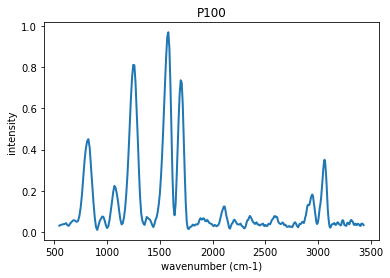

In [27]:
P100 = df[df['label'] == 'P'].iloc[:,:-4]
plt.plot(wavenumber,P100.iloc[1,:],linewidth=2)
plt.title("P100")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("intensity")

In [ ]:
df['label'].value_counts()

In [ ]:
C100 = df[df['label'] == 'C'].iloc[:,:-4]
for i in range(C100.shape[0]):
    plt.plot(wavenumber,C100.iloc[i,:])
plt.title("C")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("intensity")

In [ ]:
P100 = df[df['label'] == 'P'].iloc[:,:-4]
for i in range(100):
    plt.plot(wavenumber,P100.iloc[i,:])
plt.title("P")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("intensity")

In [ ]:
PC_1 = df[df['label'] == 'P/C and P>=70'].iloc[:,:-4]
for i in range(97):
    plt.plot(wavenumber,PC_1.iloc[i,:])
plt.title("PC and P>=70")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("intensity")

In [ ]:
PC_2 = df[df['label'] == 'P/C and P<70'].iloc[:,:-4]
for i in range(100):
    plt.plot(wavenumber,PC_2.iloc[i,:])
plt.title("PC and P<70")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("intensity")

In [ ]:
PS = df[df['label'] == 'PS'].iloc[:,:-4]
for i in range(PS.shape[0]):
    plt.plot(wavenumber,PS.iloc[i,:])
plt.title("PS")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("intensity")

In [ ]:
others = df[df['label'] == 'others'].iloc[:,:-4]
for i in range(others.shape[0]):
    plt.plot(wavenumber,others.iloc[i,:])
plt.title("others")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("intensity")

In [28]:
df.shape

(1727, 346)

In [2]:
#df = df.drop(df.iloc[195].name)
import pandas as pd
import numpy as np

df.to_csv("./Raman_6_cls_3.csv")

NameError: name 'df' is not defined

In [138]:
data = pd.read_csv("./Raman_6_cls_3.csv",index_col=0)
print(data.shape)
data['cls'].value_counts()

(1727, 346)


4    466
0    466
1    382
3    216
2     99
5     98
Name: cls, dtype: int64

In [56]:
data[data['label']=='C']

0         1         2         3         4         5         6  \
36    0.069516  0.074434  0.081158  0.089689  0.100025  0.114703  0.120813   
37    0.196991  0.184912  0.172685  0.160310  0.147787  0.112750  0.100969   
38    0.166590  0.161840  0.157857  0.154640  0.152189  0.122342  0.119809   
39    0.082858  0.096488  0.104826  0.107871  0.105623  0.085493  0.073271   
40    0.084679  0.096658  0.106037  0.112817  0.116997  0.103736  0.108062   
...        ...       ...       ...       ...       ...       ...       ...   
1912  0.154459  0.131935  0.114710  0.102786  0.096162  0.078872  0.080913   
1913  0.144980  0.154046  0.157062  0.154029  0.144948  0.109400  0.074114   
1914  0.062755  0.079775  0.092110  0.099761  0.102729  0.098251  0.076621   
1915  0.138203  0.138754  0.138546  0.137579  0.135852  0.125282  0.100894   
1916  0.123066  0.137647  0.147599  0.152921  0.153612  0.127805  0.104074   

             7         8         9  ...       336       337       338  \
36    0.142977  0.159151  0.149605  ...  0.105211  0.129701  0.127878   
37    0.116653  0.118610  0.139467  ...  0.130886  0.124997  0.123915   
38    0.146224  0.165713  0.153700  ...  0.167781  0.163083  0.152811   
39    0.057297  0.068358  0.086803  ...  0.154749  0.162680  0.155958   
40    0.123389  0.124615  0.128576  ...  0.113174  0.111161  0.100791   
...        ...       ...       ...  ...       ...       ...       ...   
1912  0.095952  0.112369  0.112811  ...  0.105432  0.115331  0.114818   
1913  0.064621  0.077789  0.090553  ...  0.126280  0.114182  0.108153   
1914  0.065777  0.076620  0.101364  ...  0.052053  0.050623  0.049851   
1915  0.090748  0.115325  0.119021  ...  0.135180  0.148160  0.138571   
1916  0.119052  0.149603  0.179280  ...  0.122468  0.110980  0.106018   

           339       340       341  label  folder_name  \
36    0.119438  0.104380  0.082705      C      2_L(82)   
37    0.124903  0.127959  0.133084      C      2_L(82)   
38    0.137266  0.116446  0.090351      C      2_L(82)   
39    0.134694  0.098887  0.048537      C      2_L(82)   
40    0.084497  0.062280  0.034139      C      2_L(82)   
...        ...       ...       ...    ...          ...   
1912  0.115489  0.117344  0.120384      C      2_L(29)   
1913  0.100186  0.090278  0.078432      C      2_L(29)   
1914  0.055013  0.066110  0.083141      C      2_L(29)   
1915  0.117914  0.086188  0.043394      C      2_L(29)   
1916  0.100513  0.094465  0.087875      C      2_L(29)   

                       file_name  cls  
36     L82_C100 20210604 (8).csv    0  
37     L82_C100 20210604 (4).csv    0  
38     L82_C100 20210604 (5).csv    0  
39     L82_C100 20210604 (9).csv    0  
40     L82_C100 20210604 (2).csv    0  
...                          ...  ...  
1912   L29_C100 20210603 (2).csv    0  
1913  L29_C100 20210603 (10).csv    0  
1914   L29_C100 20210603 (7).csv    0  
1915   L29_C100 20210603 (6).csv    0  
1916  L29_C100 20210603 (11).csv    0  

[466 rows x 346 columns]

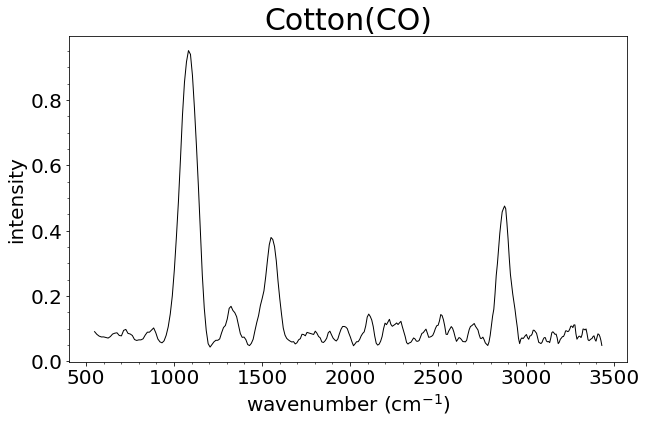

In [93]:
C = data[data['label']=='C'].iloc[14][:-4]
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size':20})
plt.plot(x,C,linewidth=1,c='black')
plt.title("Cotton(CO)",fontsize=30)
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("intensity")
plt.minorticks_on()
plt.xlabel("wavenumber (cm$^{−1}$)") #$^{n+1}$

plt.show()

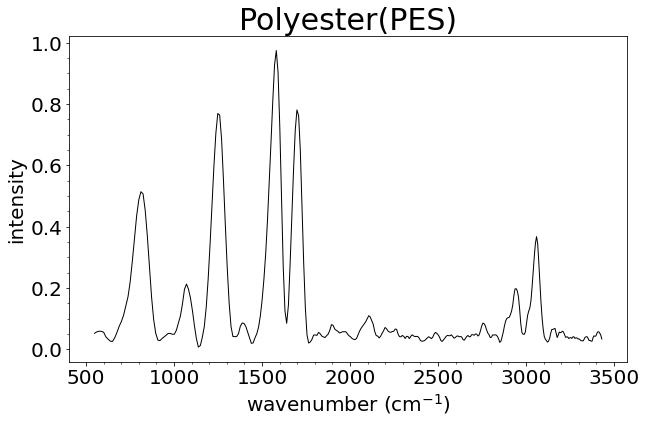

In [122]:
P = data[data['label']=='P'].iloc[8][:-4]
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size':20})
plt.plot(x,P,linewidth=1,c='black')
plt.title("Polyester(PES)",fontsize=30)
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("intensity")
plt.minorticks_on()
plt.xlabel("wavenumber (cm$^{−1}$)") #$^{n+1}$
plt.show()

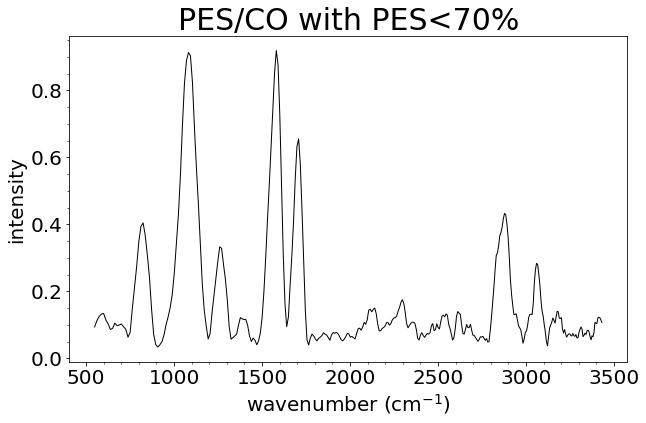

In [111]:
PC_1 = data[data['label']=='P/C and P<70'].iloc[14][:-4]
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size':20})
plt.plot(x,PC_1,linewidth=1,c='black')
plt.title("PES/CO with PES<70%",fontsize=30)
plt.xlabel("wavenumber (cm$^{−1}$)") #$^{n+1}$
plt.ylabel("intensity")
plt.minorticks_on()

plt.show()

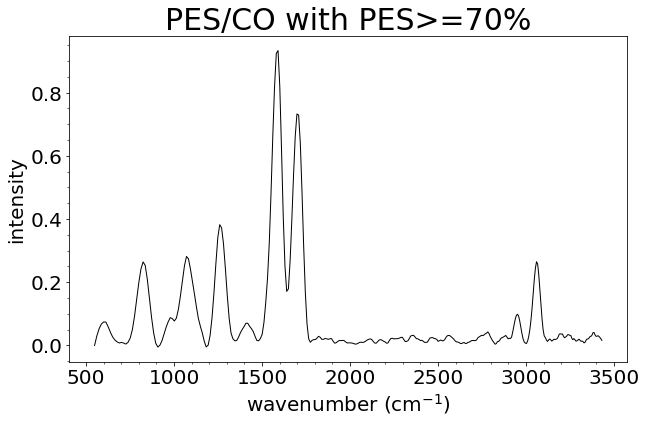

In [115]:
PC_2 = data[data['label']=='P/C and P>=70'].iloc[10][:-4]
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size':20})
plt.plot(x,PC_2,linewidth=1,c='black')
plt.title("PES/CO with PES>=70%",fontsize=30)
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("intensity")
plt.minorticks_on()
plt.xlabel("wavenumber (cm$^{−1}$)") #$^{n+1}$
plt.show()

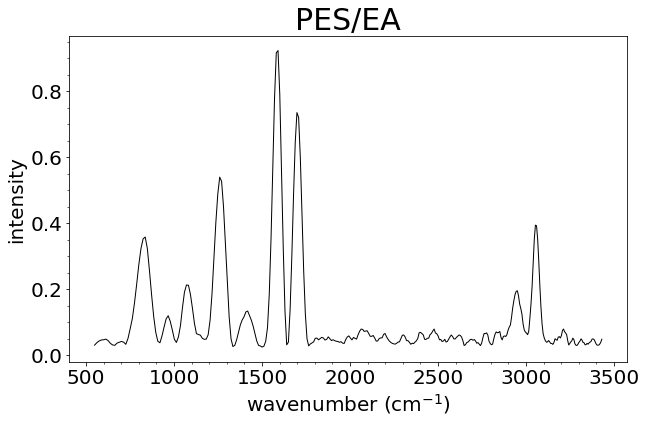

In [131]:
PS = data[data['label']=='PS'].iloc[5][:-4]
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size':20})
plt.plot(x,PS,linewidth=1,c='black')
plt.title("PES/EA",fontsize=30)
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("intensity")
plt.minorticks_on()
plt.xlabel("wavenumber (cm$^{−1}$)") #$^{n+1}$
plt.show()

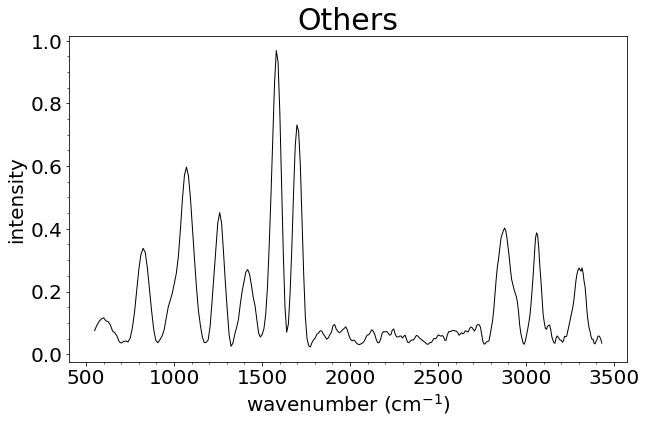

In [132]:
other = data[data['label']=='others'].iloc[5][:-4]
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size':20})
plt.xlabel("wavenumber (cm$^{−1}$)") #$^{n+1}$
plt.plot(x,other,linewidth=1,c='black')
plt.title("Others",fontsize=30)
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("intensity")
plt.minorticks_on()
plt.show()

In [139]:
test_C1 = data[data['folder_name'] == '2_L(41)']
test_C2 = data[data['folder_name'] == '2_L(43)']
test_C3 = data[data['folder_name'] == '2_L(77)']
test_C4 = data[data['folder_name'] == '2_L(78)']
test_C3 = data[data['folder_name'] == '2_L(84)']
test_C5 = data[data['folder_name'] == '2_L(96)']
test_C6 = data[data['folder_name'] == '2_L(99)']
test_C7 = data[data['folder_name'] == '2_SK(9)']
test_C8 = data[data['folder_name'] == '2_SK(10)']

test_C100 = pd.concat([test_C1,test_C2,test_C3,test_C4,test_C5,test_C6,test_C7,test_C8])

test_P1 = data[data['folder_name'] == '1_L(123)']
test_P2 = data[data['folder_name'] == '1_L(124)']
test_P3 = data[data['folder_name'] == '1_SK(5)']
test_P4 = data[data['folder_name'] == '1_SK(7)']
test_P5 = data[data['folder_name'] == '1_W(33)']
test_P6 = data[data['folder_name'] == '1_W(38)']
test_P7 = data[data['folder_name'] == '1_W(75)']
test_P8 = data[data['folder_name'] == '1_W(76)']

test_P100 = pd.concat([test_P1,test_P2,test_P3,test_P4,test_P5,test_P6,test_P7,test_P8])

test_PC1 = data[data['folder_name'] == '4_W(92)']
test_PC2 = data[data['folder_name'] == '4_W(93)']
test_PC_1 = pd.concat([test_PC1,test_PC2])

test_PC3 = data[data['folder_name'] == '5_L(4)']
#test_PC4 = data[data['folder_name'] == '6_SK(11)'] # 11
test_PC5 = data[data['folder_name'] == '5_W(20)']
test_PC6 = data[data['folder_name'] == '5_L(11)']
test_PC7 = data[data['folder_name'] == '5_L(16)']
test_PC8 = data[data['folder_name'] == '5_L(20)']
test_PC_2 = pd.concat([test_PC3,test_PC5,test_PC6,test_PC7,test_PC8])

test_PS1 = data[data['folder_name'] == '8_SK121']
test_PS2 = data[data['folder_name'] == '8_SK123']
test_PS3 = data[data['folder_name'] == '9_W(81)'] # '      ' '        '  
test_PS4 = data[data['folder_name'] == '9_SK88']  #'8_W(85)' '10_W(83)'  
test_PS5 = data[data['folder_name'] == '9_SK89']  #'8_W(86)' '10_W(84)'
test_PS6 = data[data['folder_name'] == '8_SK51']
test_PS7 = data[data['folder_name'] == '8_SK52']  
test_PS8 = data[data['folder_name'] == '8_SK58']
test_PS9 = data[data['folder_name'] == '8_SK59']
test_PS10 = data[data['folder_name'] == '8_SK60']
test_PS = pd.concat([test_PS1,test_PS2,test_PS4,test_PS5,test_PS6,test_PS7,test_PS8,test_PS9,test_PS10])

test_other1 = data[data['folder_name'] == '3_SK(3)']
test_other2 = data[data['folder_name'] == '6_W(34)']
test_others = pd.concat([test_other1,test_other2])

test_data = pd.concat([test_P100, test_C100, test_PC_1,test_PC_2,test_PS,test_others])

print(test_data.shape)
test_data['label'].value_counts()

(294, 346)


C                90
P                88
P/C and P<70     41
PS               37
others           24
P/C and P>=70    14
Name: label, dtype: int64

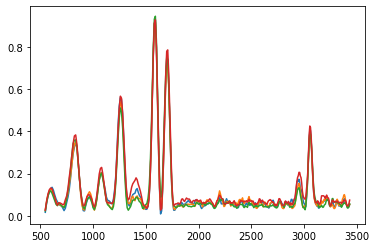

In [134]:
for i in range(test_PS5.shape[0]):
    plt.plot(wavenumber,test_PS5.iloc[i,:-4])

In [384]:
data.shape

(1727, 346)

In [140]:
print(data.shape)
print(test_data.shape)
print(test_data['label'].value_counts())
train_data = data.drop(index=test_data.index)
print(train_data.shape)
train_data['label'].value_counts()
train_data.shape

(1727, 346)
(294, 346)
C                90
P                88
P/C and P<70     41
PS               37
others           24
P/C and P>=70    14
Name: label, dtype: int64
(1433, 346)


(1433, 346)

(1433, 346)

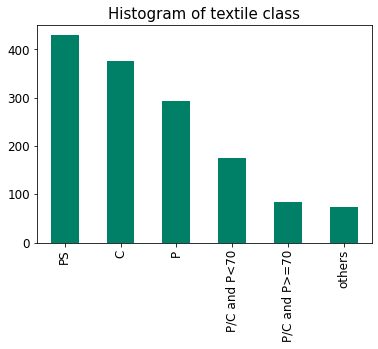

In [141]:
train_data['label'].value_counts().plot(kind='bar',colormap='summer')
plt.xticks(rotation = '90')
plt.tick_params(labelsize=12)
plt.title("Histogram of textile class",fontsize=15)
train_data.shape

In [142]:
aug_data_1 = train_data[train_data['label']=='P/C and P>=70']
aug_data_2 = train_data[train_data['label']=='others']
train_data = pd.concat([train_data,aug_data_1,aug_data_1,aug_data_2,aug_data_2])

{'PS': 429, 'C': 376, 'P': 294, 'P/C and P>=70': 255, 'others': 222, 'P/C and P<70': 175}
(1751, 346)


Text(0.5, 1.0, 'Histogram of textile class')

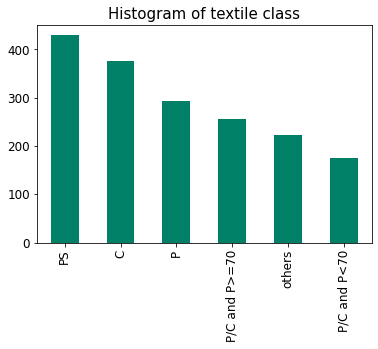

In [143]:
hist = train_data['label'].value_counts()
print(dict(hist))
print(train_data.shape)
hist.plot(kind='bar',colormap='summer')
plt.xticks(rotation = '90')
plt.tick_params(labelsize=12)
plt.title("Histogram of textile class",fontsize=15)

In [182]:
X = train_data.iloc[:,:-4]
label = train_data['label']
y = train_data['cls']

In [183]:
label

36           C
37           C
38           C
39           C
40           C
         ...  
1825    others
1826    others
1827    others
1828    others
1829    others
Name: label, Length: 1751, dtype: object

In [283]:
X3 = X2.reset_index(drop=True)

In [286]:
X3.loc[1751] = normed.reshape(-1)

In [330]:
import plotly.express as px



fig = px.scatter(df_pca, x='PC1', y='PC2',color=c2)
fig.show()

In [186]:
X_pca.shape

(1751, 15)

[0.56521742 0.77739347 0.8400986  0.89117008 0.92077302 0.93550711
 0.94531298 0.95328149 0.95845589 0.963217   0.96684627 0.96966104
 0.97207041 0.97426143 0.97595086]


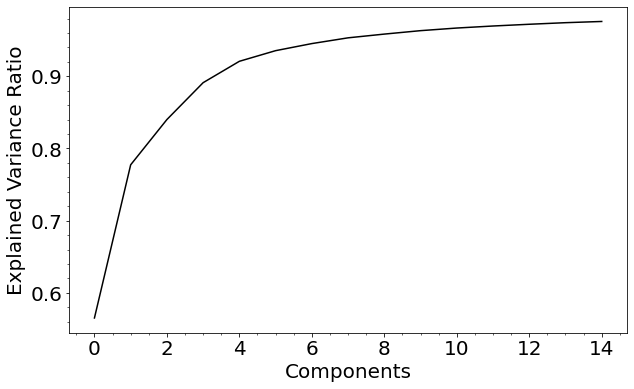

In [184]:
pca = PCA(n_components=15)

X_pca = pca.fit_transform(X)

plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size':20})
plt.plot(np.cumsum(pca.explained_variance_ratio_),c="black")
plt.xlabel("Components")
plt.ylabel("Explained Variance Ratio")
plt.minorticks_on()

print(np.cumsum(pca.explained_variance_ratio_))

In [388]:
test_data[test_data['label']=='others'].shape

(24, 346)

In [20]:
print(test_data.shape)
test_data['label'].value_counts()

(294, 346)


C                90
P                88
P/C and P<70     41
PS               37
others           24
P/C and P>=70    14
Name: label, dtype: int64

In [187]:
X_test = test_data.iloc[:,:-4]
y_test = test_data['cls']

X_test_pca = pca.transform(X_test)
X_test_pca.shape
test_data

0         1         2         3         4         5         6  \
270   0.018289  0.030713  0.039440  0.044469  0.045800  0.041981  0.036377   
271   0.021664  0.031893  0.038750  0.042234  0.042347  0.035393  0.025618   
272   0.033009  0.046149  0.054862  0.059147  0.059006  0.046704  0.038818   
273   0.016487  0.034297  0.046611  0.053428  0.054748  0.045187  0.035243   
274   0.021449  0.024742  0.027546  0.029861  0.031687  0.032919  0.029059   
...        ...       ...       ...       ...       ...       ...       ...   
1086  0.029810  0.047462  0.060010  0.067454  0.069793  0.060938  0.053434   
1087  0.052118  0.056894  0.059089  0.058703  0.055736  0.041641  0.028822   
1088  0.024054  0.053584  0.075098  0.088595  0.094076  0.089135  0.079534   
1089  0.040146  0.066986  0.086002  0.097195  0.100566  0.090736  0.078729   
1090  0.018970  0.047843  0.067606  0.078260  0.079803  0.065018  0.042242   

             7         8         9  ...       336       337       338  \
270   0.028942  0.021870  0.016407  ...  0.035048  0.037531  0.036832   
271   0.016358  0.017371  0.017759  ...  0.025753  0.026463  0.025499   
272   0.038147  0.034650  0.037886  ...  0.057551  0.066034  0.062809   
273   0.027348  0.023657  0.026356  ...  0.020270  0.022288  0.022618   
274   0.023937  0.033356  0.036938  ...  0.044082  0.049193  0.046997   
...        ...       ...       ...  ...       ...       ...       ...   
1086  0.049146  0.045230  0.035908  ...  0.042465  0.051141  0.051179   
1087  0.022127  0.024953  0.025805  ...  0.044075  0.046486  0.045401   
1088  0.056072  0.042322  0.032633  ...  0.057032  0.053904  0.048141   
1089  0.059210  0.046041  0.041458  ...  0.052918  0.056737  0.055531   
1090  0.025324  0.018361  0.017555  ...  0.029057  0.031973  0.030901   

           339       340       341   label  folder_name  \
270   0.033582  0.027780  0.019427       P     1_L(123)   
271   0.024429  0.023254  0.021974       P     1_L(123)   
272   0.055239  0.043326  0.027070       P     1_L(123)   
273   0.022835  0.022939  0.022931       P     1_L(123)   
274   0.042775  0.036526  0.028250       P     1_L(123)   
...        ...       ...       ...     ...          ...   
1086  0.047094  0.038888  0.026559  others      6_W(34)   
1087  0.042465  0.037681  0.031046  others      6_W(34)   
1088  0.040612  0.031317  0.020255  others      6_W(34)   
1089  0.053188  0.049708  0.045091  others      6_W(34)   
1090  0.029665  0.028262  0.026694  others      6_W(34)   

                           file_name  cls  
270       L123_P100 20210601 (5).csv    1  
271       L123_P100 20210601 (9).csv    1  
272       L123_P100 20210601 (8).csv    1  
273       L123_P100 20210601 (4).csv    1  
274       L123_P100 20210601 (3).csv    1  
...                              ...  ...  
1086   W34_rP65rN35 20210601 (1).csv    5  
1087   W34_rP65rN35 20210601 (7).csv    5  
1088  W34_rP65rN35 20210601 (10).csv    5  
1089  W34_rP65rN35 20210601 (11).csv    5  
1090   W34_rP65rN35 20210601 (6).csv    5  

[294 rows x 346 columns]

In [188]:
print(X_pca.shape)
print(X.shape)

(1751, 15)
(1751, 342)


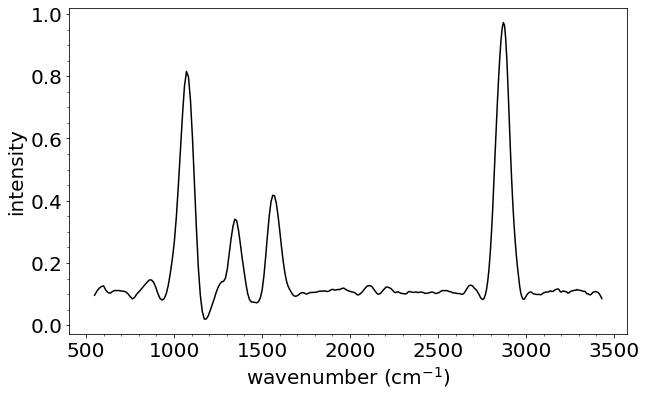

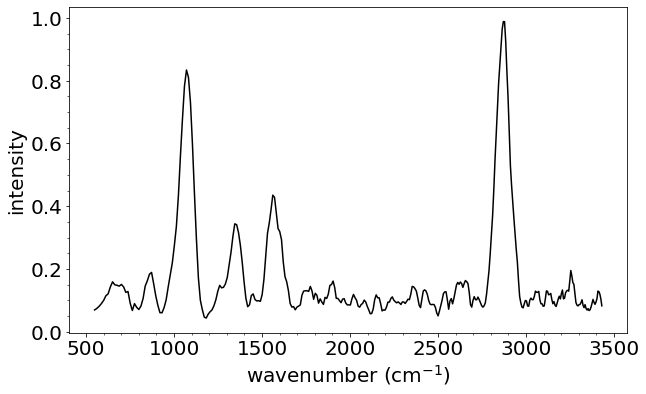

In [151]:
plt.figure(figsize=(10,6))
plt.plot(wavenumber,pca.inverse_transform(X_pca[0]),c='black')
plt.minorticks_on()


plt.rcParams.update({'font.size':20})

#plt.title("Raman spectrum with PC=15",fontsize=30)
plt.xlabel("wavenumber (cm$^{−1}$)") #$^{n+1}$
plt.ylabel("intensity")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(wavenumber,np.array(X.iloc[0]),c='black')
plt.minorticks_on()
#plt.title("orignial Raman spectrum",fontsize=30)
plt.xlabel("wavenumber (cm$^{−1}$)") #$^{n+1}$
plt.ylabel("intensity")
plt.show()

In [472]:
print(y.shape)

(1751,)


from scipy.signal import find_peaks
import math

X_reduce = pca.inverse_transform(X_pca)

print(y.iloc[0])
peak, peak_value = find_peaks(X_reduce[0], height=0.14)
print(np.round(wavenumber[peak]))
plt.plot(wavenumber[peak],peak_value['peak_heights'],"x",c='red')
plt.plot(wavenumber,X_reduce[0], label='C100 restored',c='blue')
plt.show()
plt.plot(wavenumber,X.iloc[0],label='C100',c='green')
plt.show()


print(y.iloc[500])
peak, peak_value = find_peaks(X_reduce[500], height=0.06)
print(np.round(wavenumber[peak]))
plt.plot(wavenumber[peak],peak_value['peak_heights'],"x",c='red')
plt.plot(wavenumber,X_reduce[500], label='P100 restored',c ='blue')
plt.show()
plt.plot(wavenumber,X.iloc[500],label='P100',c='green')
plt.show()

print(y.iloc[1000])
peak, peak_value = find_peaks(X_reduce[1000], height=0.1)
print(np.round(wavenumber[peak]))
plt.plot(wavenumber[peak],peak_value['peak_heights'],"x",c='red')
plt.plot(wavenumber,X_reduce[1000], label='PC and P<70 restored',c='blue')
plt.show()
plt.plot(wavenumber,X.iloc[1000],label='PC and P<70',c='green')
plt.legend()
plt.show()

print(y.iloc[1300])
peak, peak_value = find_peaks(X_reduce[1300], height=0.08)
print(np.round(wavenumber[peak]))
plt.plot(wavenumber[peak],peak_value['peak_heights'],"x",c='red')
plt.plot(wavenumber,X_reduce[1300], label='PC and P<70 restored',c='blue')
plt.show()
plt.plot(wavenumber,X.iloc[1300],label='PC and P<70',c='green')
plt.show()


print(y.iloc[1700])
peak, peak_value = find_peaks(X_reduce[1700], height=0.1)
print(np.round(wavenumber[peak]))
plt.plot(wavenumber[peak],peak_value['peak_heights'],"x",c='red')
plt.plot(wavenumber,X_reduce[1700], label='PS_restored',c='blue')
plt.show()
plt.plot(wavenumber,X.iloc[1700],label='PS',c='green')
print(np.round(wavenumber[peak]))
plt.show()


plt.title("PC1")
plt.plot(wavenumber,pca.components_[0],label='PC1')
#plt.plot(wavenumber,abs(pca.components_[0]))
peaks, _ = find_peaks(abs(pca.components_[0]), height=0.02)
plt.plot(wavenumber[peaks],pca.components_[0][peaks], "x",c='red')
print(np.round(wavenumber[peaks])) 

plt.title("PC2")
plt.plot(wavenumber,pca.components_[1],label='PC2')
peaks, _ = find_peaks(abs(pca.components_[1]), height=0.015)
plt.plot(wavenumber[peaks],pca.components_[1][peaks], "x",c='red')
print(np.round(wavenumber[peaks])) 

plt.title("PC4")
plt.plot(wavenumber,pca.components_[3],label='PC4')
peaks, _ = find_peaks(abs(pca.components_[3]), height=0.04)
plt.plot(wavenumber[peaks],pca.components_[3][peaks], "x",c='red')
print(np.round(wavenumber[peaks])) 

In [157]:
fabric_cls =dict({0:"CO",1:"PES",2:"PES/CO with PES>=70",3:"PES/CO and PES<70",4:"PES/EA",5:"Others"})

In [365]:
df_pca = pd.DataFrame(X_pca)
df_pca.rename(columns={0: "PC1", 1: "PC2",2: "PC3", 3: "PC4",4: "PC5", 5: "PC6",
                      6: "PC7", 7: "PC8",8: "PC9", 9: "PC10",10: "PC11", 11: "PC12",
                      12: "PC13", 13: "PC14",14: "PC15"},inplace=True)

In [49]:
import plotly.express as px

c2 = train_data['label'].values
#c = y.astype(str)

fig = px.scatter(df_pca, x='PC1', y='PC2',color=c2)
fig.show()

In [51]:
import plotly.express as px

c2 = train_data['label'].values
#c = y.astype(str)

fig = px.scatter(df_pca, x='PC1', y='PC4',color=c2)
fig.show()

In [50]:
import plotly.express as px

c2 = train_data['cls'].values
print(len(c2))
c = y.astype(str)
fig = px.scatter(df_pca, x='PC1', y='PC2',color=c2)
fig.show()

1751


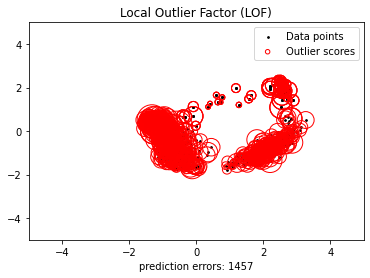

In [52]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
y_pred = clf.fit_predict(X_pca)
n_errors = (y_pred != y).sum()
X_scores = clf.negative_outlier_factor_


import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection


def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])


plt.scatter(X_pca[:, 0], X_pca[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
plt.legend(
    handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
)
plt.title("Local Outlier Factor (LOF)")
plt.show()

In [53]:
c2 = train_data['label'].values
print(len(c2))
c = y.astype(str)

fig = px.scatter(df_pca, x='PC1', y='PC4',color=c2)

fig.show()

1751


In [54]:
from sklearn.manifold import TSNE
tsne = TSNE()
tsne.fit_transform(X)
X_tsne = tsne.embedding_
print(tsne.embedding_)

[[-47.30953     3.6226907]
 [-58.53387     9.4545   ]
 [-47.619305    3.979769 ]
 ...
 [-54.51744   -35.57305  ]
 [-53.6161    -34.106327 ]
 [-51.43709   -34.01218  ]]


In [55]:
fig = px.scatter(tsne.embedding_, x=0, y=1, color=label)
fig.show()

# Cross validation

https://scikit-learn.org/stable/modules/cross_validation.html

In [189]:
labels = ['CO','PES','PES/CO with PES>=70','PES/CO with PES<70','PES/EA','Others']
#X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val, test_size=0.2, random_state=42)

In [190]:
X_train = X_pca
y_train = y
X_train.shape

X_train = np.array(X_train)
y_train = np.array(y_train).astype('int')
X_test = np.array(X_test)
y_test = np.array(y_test).astype('int')

y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5])

In [181]:
from sklearn.model_selection import cross_val_predict
y_train.shape

(342,)

# KNN

In [191]:
nn = [2,3,4,5,10]
scores_mean = []
scores_std = []
for i in range(len(nn)):
    KNN = KNeighborsClassifier(n_neighbors=nn[i])
    scores_mean.append(cross_val_score(KNN,X_train,y_train,cv=5).mean())
    scores_std.append(cross_val_score(KNN,X_train,y_train,cv=5).std())

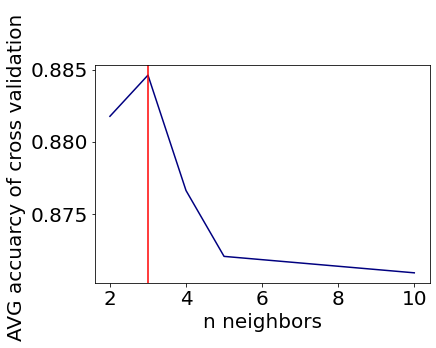

Text(0, 0.5, 'STD of 5 fold cross validation ')

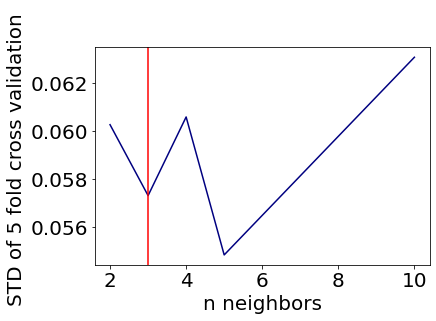

In [192]:
plt.plot(nn,scores_mean,c='navy')
plt.axvline(x = 3, color = 'r', label = 'axvline - full height')
plt.xlabel("n neighbors")
plt.ylabel("AVG accuarcy of cross validation ")
plt.show()
plt.plot(nn,scores_std,c='navy')
plt.axvline(x = 3, color = 'r', label = 'axvline - full height')
plt.xlabel("n neighbors",)
plt.ylabel("STD of 5 fold cross validation ")

In [193]:
KNN = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(KNN,X_train,y_train,cv=5)
KNN_scores = scores

[0.06026663373967519,
 0.05729788455074936,
 0.06059015670868934,
 0.05481369918476374,
 0.06309041875201078]

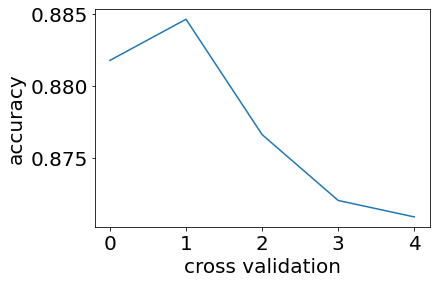

In [194]:
plt.plot(scores_mean)
plt.xlabel("cross validation")
plt.ylabel("accuracy")
scores_std

In [195]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_val_score

KNN = KNeighborsClassifier(n_neighbors=3)
KNN.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

# Test Data on KNN

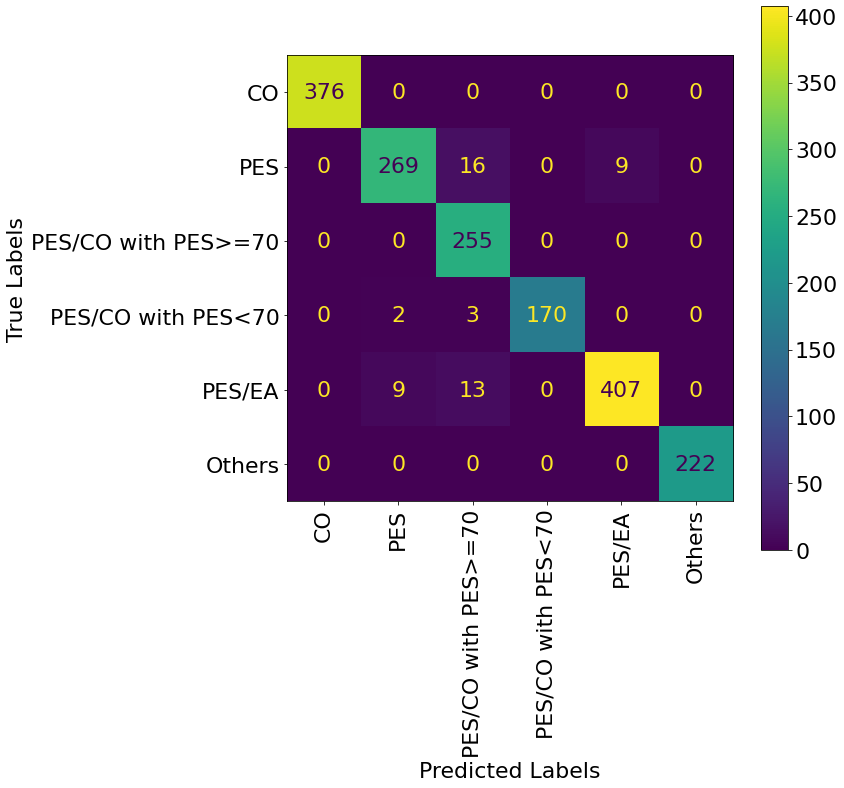

In [254]:
pred = KNN.predict(X_train)


cm = confusion_matrix(y_train, pred, labels=KNN.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(xticks_rotation='vertical')
fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10) 
plt.rcParams.update({'font.size':22})

plt.xlabel('Predicted Labels')  # Font size for x-axis label
plt.ylabel('True Labels')  # Font size for y-axis label
#plt.title('Confusion Matrix', fontsize=16)  # Font size for the title



plt.show()

(1751, 15)
(294, 342)


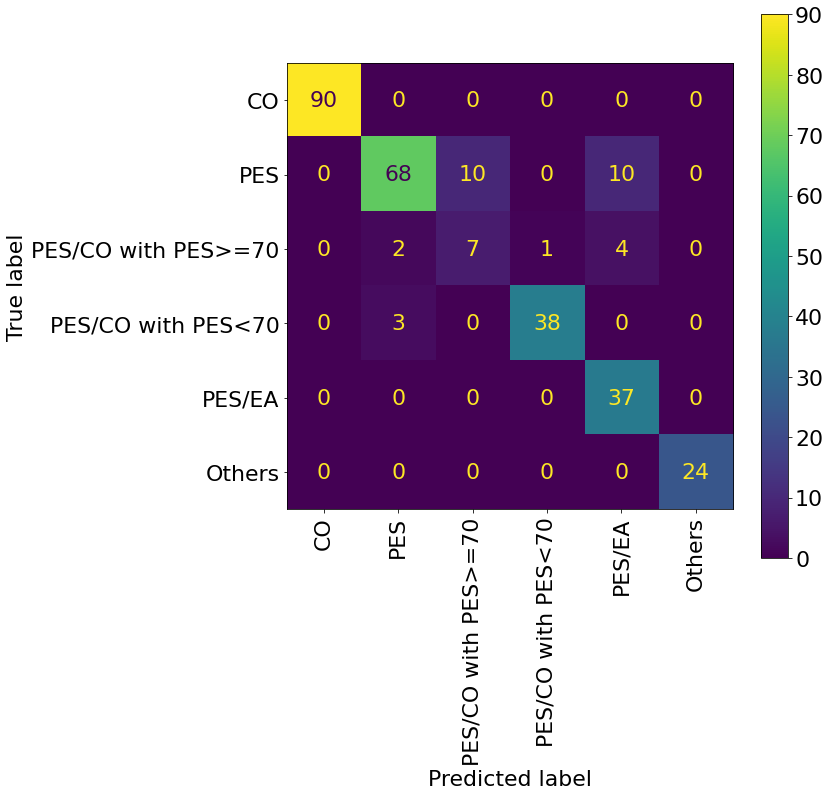

KNN 
train acc:  0.9703026841804683
test acc:  0.8979591836734694


In [255]:
print(X_train.shape)
KNN = KNeighborsClassifier(n_neighbors=4)
KNN.fit(X_train,y_train)
print(X_test.shape)


pred = KNN.predict(pca.transform(X_test))
cm = confusion_matrix(y_test, pred, labels=KNN.classes_)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation='vertical')
fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10) 
plt.rcParams.update({'font.size':22})

plt.show()
print("KNN ")
print("train acc: ",accuracy_score(y_train,KNN.predict(X_train)))
print("test acc: ",accuracy_score(y_test,pred))

KNN_train_acc = accuracy_score(y_train,KNN.predict(X_train))
KNN_test_acc = accuracy_score(y_test,pred)

Text(0, 0.5, 'accuracy')

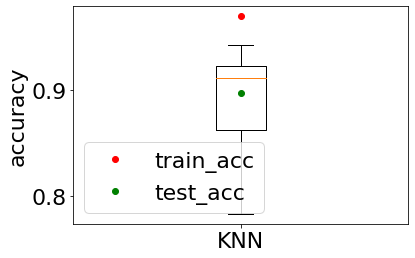

In [256]:
knn_result = [KNN_scores,KNN_train_acc,KNN_test_acc]
plt.boxplot(knn_result[0])
plt.plot(1,knn_result[1],'ro',label='train_acc')
plt.plot(1,knn_result[2],'go',label='test_acc')
plt.legend()
plt.xticks([1], ['KNN'])
plt.ylabel("accuracy")

In [401]:
train_data['label'].value_counts()

PS               429
C                376
P                294
P/C and P>=70    255
others           222
P/C and P<70     175
Name: label, dtype: int64

In [ ]:
train_data.shape

In [65]:
pca_data = pd.DataFrame(X_test)
pca_data['cls'] = y_test

# test unknown data
test = file_read_norm("./New_data/20240131/100%P/S7.csv")
pca_test = pca.transform(test.reshape(1,-1))
print("GT: P100")
print("KNN: ",fabric_cls[KNN.predict(pca_test)[0]])
print("SVC: ",fabric_cls[svc.predict(pca_test)[0]])
print("RF: ",fabric_cls[RF.predict(pca_test)[0]])
print("ANN: ",fabric_cls[ann.predict(test.reshape(-1,342)).argmax()])
print("CNN: ",fabric_cls[cnn.predict(test.reshape(-1,342,1)).argmax()])
print("     ")
P100 = file_read_norm("./Final_Database/1_L(130)/L130_P100 20210601 (4).csv")
pca_p100 = pca.transform(P100.reshape(1,-1))
print("GT: P100")
print("KNN: ",fabric_cls[KNN.predict(pca_p100)[0]])
print("SVC: ",fabric_cls[svc.predict(pca_p100)[0]])
print("RF: ",fabric_cls[RF.predict(pca_p100)[0]])
print("ANN: ",fabric_cls[ann.predict(P100.reshape(-1,342)).argmax()])
print("CNN: ",fabric_cls[cnn.predict(P100.reshape(-1,342,1)).argmax()])



# SVC

In [257]:
from sklearn.svm import SVC
tuned_params = [{'kernel':['rbf'],'gamma':[1e-1,1e-2,1e-3,1e-4,1e-5],
                'C':[1,10,100,1000,10000,100000,500000,1000000]}]

In [258]:
clf = GridSearchCV(SVC(),tuned_params,cv=5,scoring = "accuracy")

clf.fit(X_train,y_train)

print(X_train.shape)


print("Best parameters set: ")
print(clf.best_params_)
print("val acc: ",clf.best_score_)


(1751, 15)
Best parameters set: 
{'C': 500000, 'gamma': 0.01, 'kernel': 'rbf'}
val acc:  0.9046267806267807


(1751, 15)
[0.9031339  0.83428571 0.96285714 0.86857143 0.95428571]


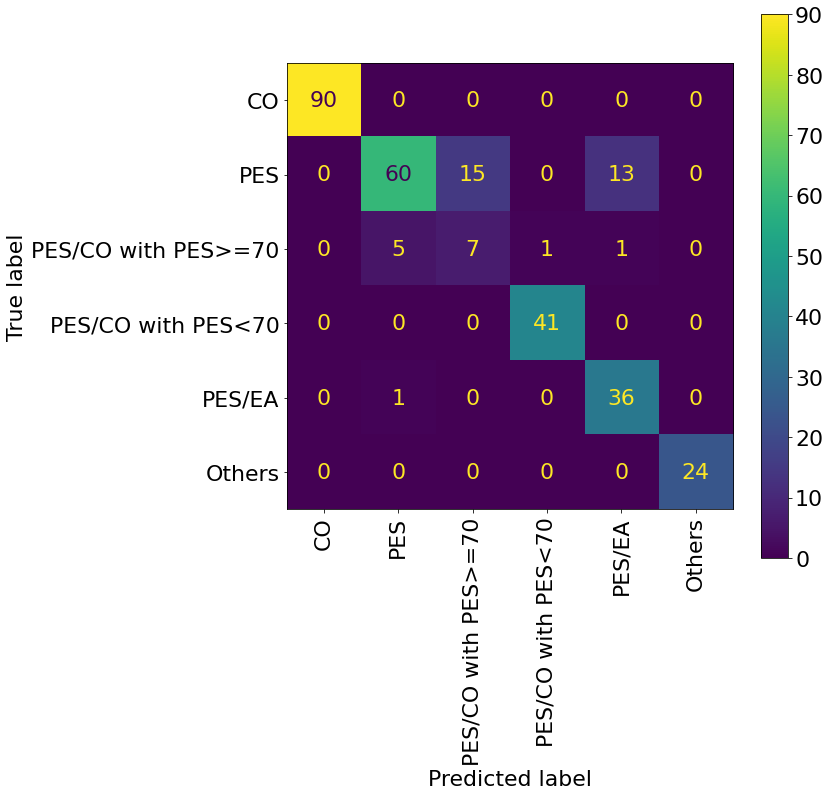

SVC : 
val acc:  0.9046267806267807
test acc:  0.8775510204081632


In [260]:
from sklearn.model_selection import cross_val_score

scores_mean = []
scores_std = []

svc = SVC(kernel='rbf',gamma=0.01,C=500000) # 0.1, 1000
svc.fit(X_train,y_train)
SVC_scores = cross_val_score(svc,X_train, y_train, cv=5)

print(X_train.shape)

print(SVC_scores)

pred = svc.predict(pca.transform(X_test))

cm = confusion_matrix(y_test, pred, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation='vertical')
fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10) 
plt.rcParams.update({'font.size':22})
plt.show()
print("SVC : ")
print("val acc: ",clf.best_score_)
print("test acc: ",accuracy_score(y_test,pred))
SVC_test_acc = accuracy_score(y_test,pred)

In [512]:
svc.probability

False

train acc:  0.9942889777270132


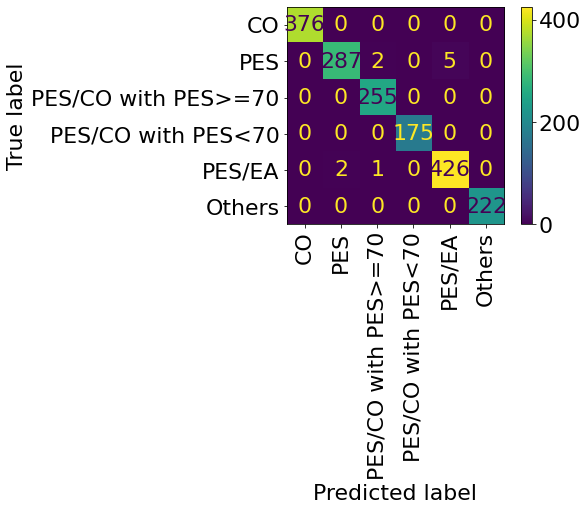

In [261]:

pred = svc.predict(X_train)
print('train acc: ',svc.score(X_train,y_train))
cm = confusion_matrix(y_train, pred, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation='vertical')

plt.show()

SVC_train_acc = svc.score(X_train,y_train)

Number of support vectors: 6


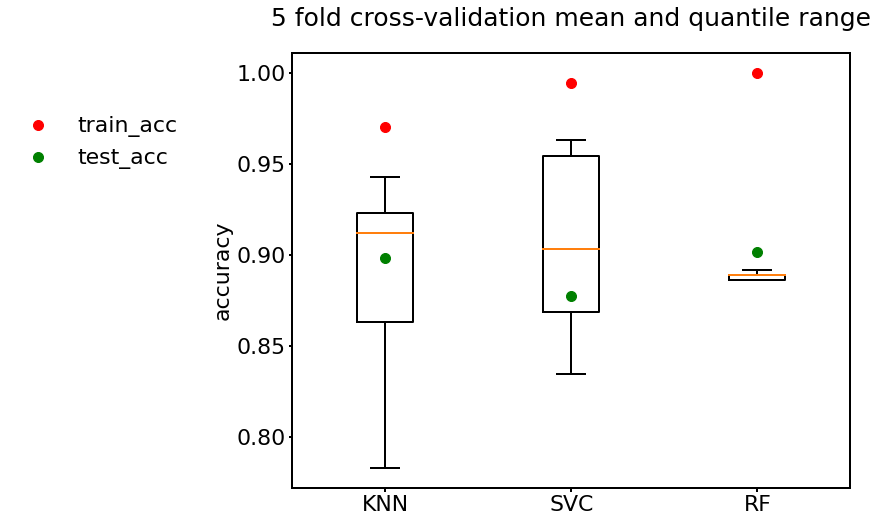

In [333]:
print('Number of support vectors:',len(svc.n_support_))

svc_result = [SVC_scores,SVC_train_acc,SVC_test_acc]
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,8))
plt.boxplot([knn_result[0],svc_result[0],RF_result[0]],
           boxprops=dict(linewidth=2),whiskerprops=dict(linewidth=2),  # Thicker whisker lines
            capprops=dict(linewidth=2),  # Thicker cap lines
            medianprops=dict(linewidth=2))

plt.plot(1,knn_result[1],'ro',label='train_acc',markersize=10)
plt.plot(1,knn_result[2],'go',label='test_acc',markersize=10)

plt.plot(2,svc_result[1],'ro',markersize=10)
plt.plot(2,svc_result[2],'go',markersize=10)

plt.plot(3,RF_result[1],'ro',markersize=10)
plt.plot(3,RF_result[2],'go',markersize=10)

plt.xticks([1,2,3], ['KNN','SVC','RF'])
plt.ylabel("accuracy")

#plt.legend(bbox_to_anchor=(-0.17, 0.9),frameon=False)

plt.text(2, max(max(knn_result[0]), max(svc_result[0]), max(RF_result[0])) + 0.06, 
         "5 fold cross-validation mean and quantile range", ha='center', va='bottom', fontsize=25)

ax = plt.gca()
ax.spines['top'].set_linewidth(2)    # Top axis line
ax.spines['right'].set_linewidth(2)  # Right axis line
ax.spines['bottom'].set_linewidth(2) # Bottom axis line
ax.spines['left'].set_linewidth(2)   # Left axis line

# Thicker ticks on x and y axes
ax.tick_params(axis='both', which='both', width=2)


# Adding the legend
plt.legend(bbox_to_anchor=(-0.17, 0.9), frameon=False)



In [675]:
np.std(knn_result[0])

0.05729788455074936

# RF with PCA n=15

In [263]:
# Random forest
RF = RandomForestClassifier()
RF_param = {"n_estimators":[100,150,200],"max_depth":[20,25,30]}
    
GSCV = GridSearchCV(RF,param_grid=RF_param,cv=5)
GSCV.fit(X_train,y_train)

print("The best model param :",GSCV.best_params_)

The best model param : {'max_depth': 25, 'n_estimators': 150}


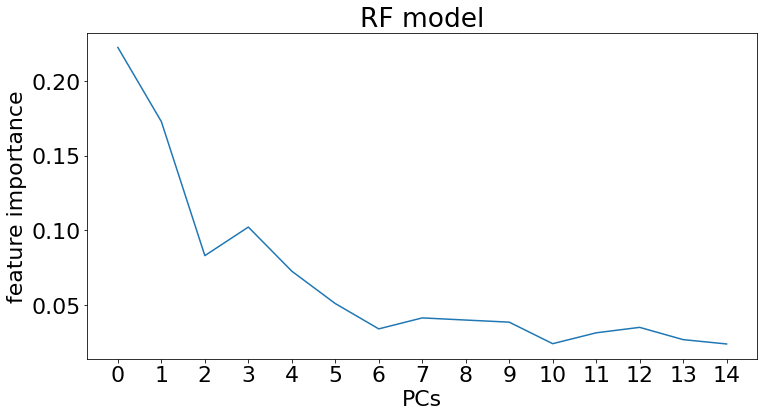

In [266]:
plt.figure(figsize=(12,6))
plt.plot(RF.feature_importances_)
plt.xlabel('PCs')
plt.xticks(np.arange(0, 15, step=1))
plt.ylabel('feature importance')
plt.title('RF model')
plt.rcParams.update({'font.size': 24})

In [267]:
RF_1 = GSCV.cv_results_['split0_test_score'][0]
RF_2 = GSCV.cv_results_['split0_test_score'][1]
RF_3 = GSCV.cv_results_['split0_test_score'][2]
RF_4 = GSCV.cv_results_['split0_test_score'][3]
RF_5 = GSCV.cv_results_['split0_test_score'][5]
RF_scores = [RF_1,RF_2,RF_3,RF_4,RF_5]

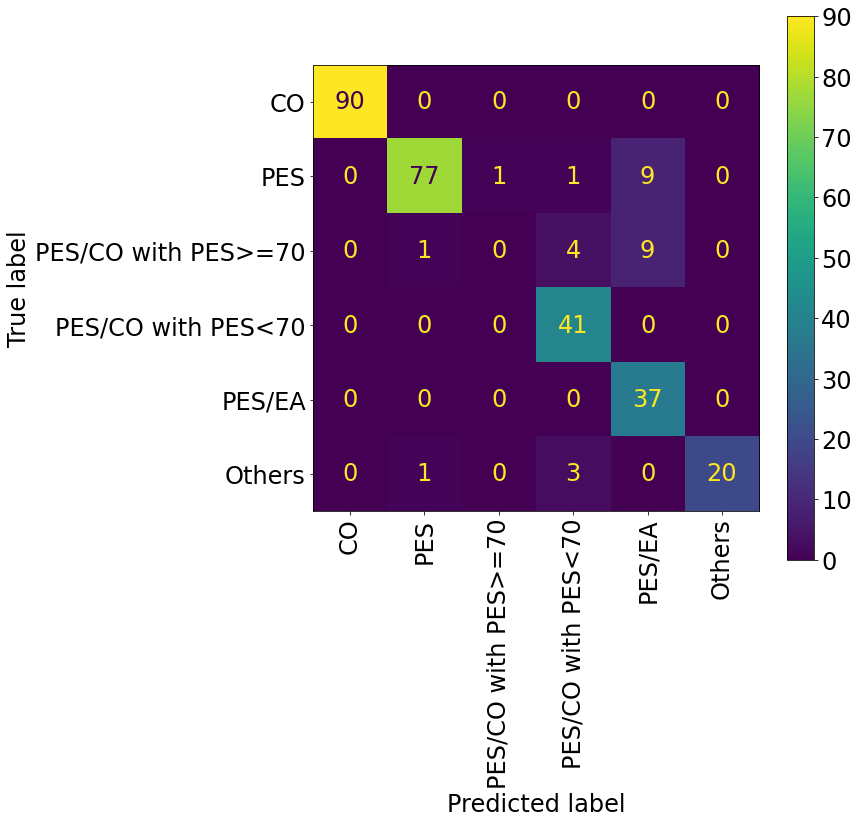

Random Forest
train acc:  1.0
test acc:  0.9013605442176871


In [269]:
RF = RandomForestClassifier(n_estimators=100, max_depth=20)
RF.fit(X_train,y_train)
pred = RF.predict(pca.transform(X_test))

cm = confusion_matrix(y_test, pred, labels=RF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation='vertical')
fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10) 
plt.rcParams.update({'font.size':22})

plt.show()

print("Random Forest")
print("train acc: ", accuracy_score(y_train, RF.predict(X_train)))
print("test acc: ", accuracy_score(y_test, pred))
RF_train_acc = accuracy_score(y_train, RF.predict(X_train))
RF_test_acc = accuracy_score(y_test, pred)

RF_result = [RF_scores,RF_train_acc,RF_test_acc]

In [78]:
fabric_cls =dict({0:"C100",1:"P100",2:"P/C and P>=70",3:"P/C and P<70",4:"PS",5:"others"})

from sklearn.tree import export_graphviz
import graphviz
from IPython import display
from sklearn import tree

dt = RF.estimators_[0]


#text_representation = tree.export_text(dt)
#print(text_representation)

fig = plt.figure(figsize=(200,100))
_ = tree.plot_tree(dt, 
                   feature_names=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10'
                                  ,'PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20'],  
                   class_names=['C100','P100','PC P>70','PC P<70','PS','others'],
                   filled=True)
fig.savefig("decistion_tree.png")

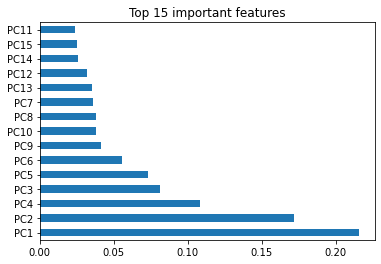

In [79]:
feat_importances = pd.Series(RF.feature_importances_, index=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10'
                                  ,'PC11','PC12','PC13','PC14','PC15'])
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 important features")
plt.show()

Text(0, 0.5, 'PC1 value')

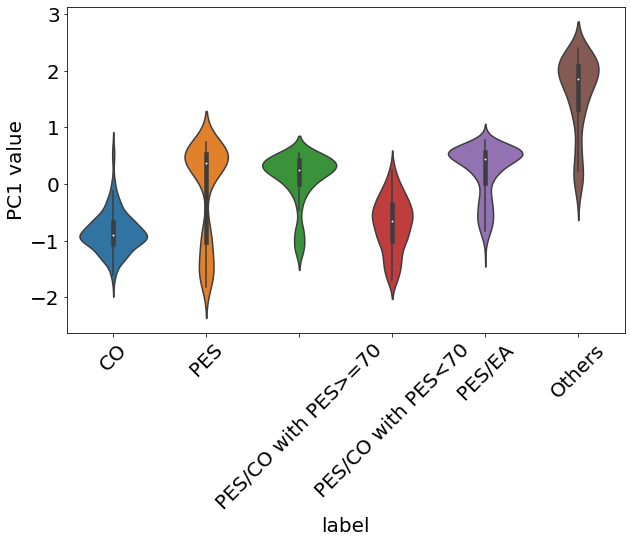

In [166]:
pca_data = pd.DataFrame(X_pca)
pca_data['label'] = np.array(y)

plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size':20})
#plt.title("PC1 violine plot",fontsize=30)
my_plot = sns.violinplot(x='label',y=1,data=pca_data)
my_plot.set_xticklabels(labels, rotation=45)
plt.ylabel("PC1 value")

Text(0, 0.5, 'PC2 value')

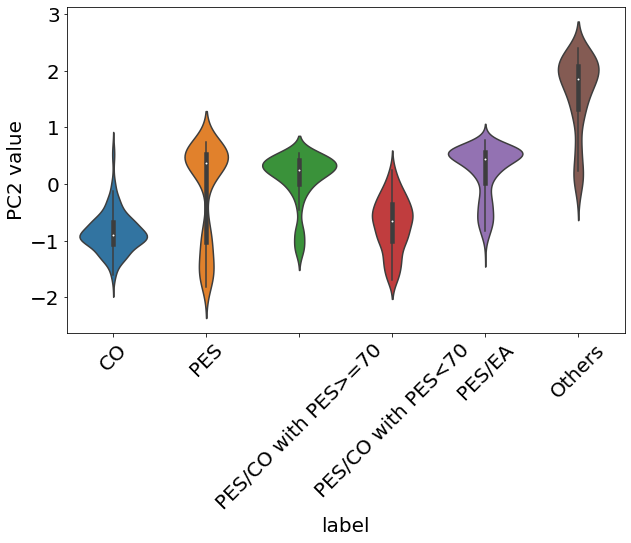

In [167]:
#plt.title("PC2 violine plot",fontsize=15)
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size':20})
my_plot = sns.violinplot(x='label',y=1,data=pca_data)
my_plot.set_xticklabels(labels, rotation=45)
plt.ylabel("PC2 value")

Text(0, 0.5, 'PC3 value')

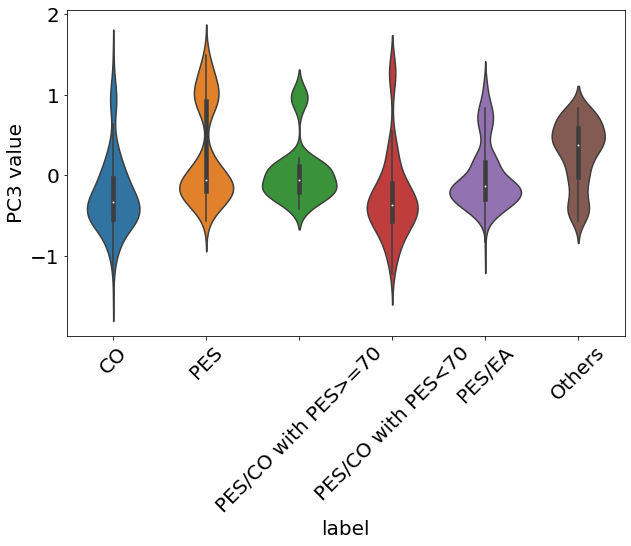

In [169]:
#plt.title("PC3 violine plot",fontsize=15)
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size':20})
my_plot = sns.violinplot(x='label',y=2,data=pca_data)
my_plot.set_xticklabels(labels, rotation=45)
plt.ylabel("PC3 value")

Text(0, 0.5, 'PC3 histigram')

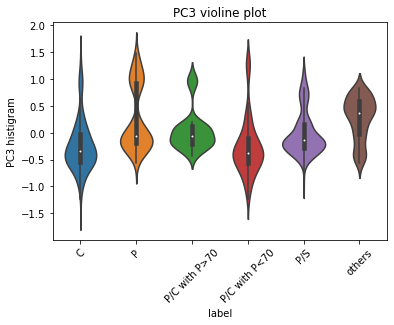

In [83]:
plt.title("PC3 violine plot")
my_plot = sns.violinplot(x='label',y=2,data=pca_data)
my_plot.set_xticklabels(labels, rotation=45)
plt.ylabel("PC3 histigram")

Text(0, 0.5, 'PC6 histigram')

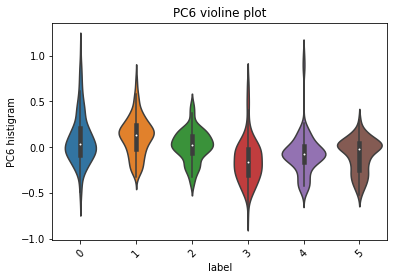

In [84]:
plt.title("PC6 violine plot")
my_plot = sns.violinplot(x='label',y=5,data=pca_data)
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
plt.ylabel("PC6 histigram")

Text(0, 0.5, 'PC11 histigram')

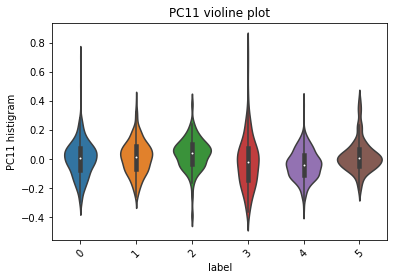

In [85]:
plt.title("PC11 violine plot")
my_plot = sns.violinplot(x='label',y=10,data=pca_data)
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
plt.ylabel("PC11 histigram")

# XGBoost

In [ ]:
xgboost.plot_importance(xgboostModel)
plt.figure(figsize = (16, 12))
plt.show()

# RF without PCA

In [88]:
labels

['C', 'P', 'P/C with P>=70', 'P/C with P<70', 'P/S', 'others']

In [25]:
X = train_data.iloc[:,:-4]
label = train_data['label']
y = train_data['cls']
print(y.shape)
print(X.shape)



(1751,)
(1751, 342)


In [26]:
X_train = np.array(X)
y_train = np.array(y).astype('int')
X_test = np.array(X_test)
y_test = np.array(y_test).astype('int')

print(X_train.shape)
X_test.shape

X_test = test_data.iloc[:,:-4]
y_test = test_data['cls']
print(X_test.shape)


(1751, 342)
(294, 342)


In [92]:
# Random forest
RF = RandomForestClassifier() 
RF_param = {"n_estimators":[10,50,100,150,200],"max_depth":[5,10,15,20]}
    
GSCV = GridSearchCV(RF,param_grid=RF_param,cv=5)
GSCV.fit(X_train,y_train)

print("The best model param :",GSCV.best_params_)

The best model param : {'max_depth': 15, 'n_estimators': 50}


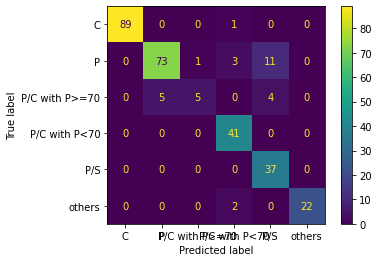

Random Forest
train acc:  1.0
test acc:  0.9081632653061225


In [93]:
RF = RandomForestClassifier(n_estimators=50, max_depth=15)
RF.fit(X_train,y_train)
pred = RF.predict(X_test)

cm = confusion_matrix(y_test, pred, labels=RF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

print("Random Forest")
print("train acc: ", accuracy_score(y_train, RF.predict(X_train)))
print("test acc: ", accuracy_score(y_test, pred))

Train Confusion Matrix


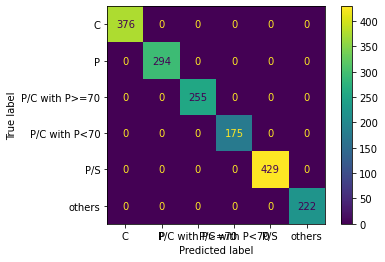

In [94]:
print("Train Confusion Matrix")
pred = RF.predict(X_train)

cm = confusion_matrix(y_train, pred, labels=RF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()



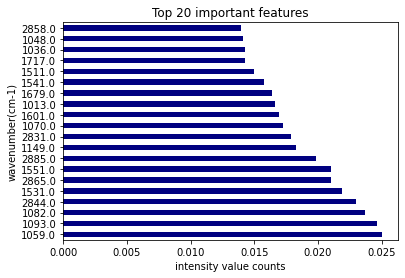

In [204]:
feat_importances = pd.Series(RF.feature_importances_, index=np.round(wavenumber))
feat_importances.nlargest(20).plot(kind='barh',color='navy')
plt.title("Top 20 important features")
plt.ylabel("wavenumber(cm-1)")
plt.xlabel("intensity value counts")
plt.show()

In [197]:
wavenumber[42]

0         1         2         3         4         5         6  \
0  0.069516  0.074434  0.081158  0.089689  0.100025  0.114703  0.120813   
1  0.196991  0.184912  0.172685  0.160310  0.147787  0.112750  0.100969   
2  0.166590  0.161840  0.157857  0.154640  0.152189  0.122342  0.119809   
3  0.082858  0.096488  0.104826  0.107871  0.105623  0.085493  0.073271   
4  0.084679  0.096658  0.106037  0.112817  0.116997  0.103736  0.108062   

          7         8         9  ...       333       334       335       336  \
0  0.142977  0.159151  0.149605  ...  0.093635  0.087520  0.094571  0.105211   
1  0.116653  0.118610  0.139467  ...  0.131192  0.132603  0.130838  0.130886   
2  0.146224  0.165713  0.153700  ...  0.109349  0.143370  0.166745  0.167781   
3  0.057297  0.068358  0.086803  ...  0.061960  0.099811  0.141076  0.154749   
4  0.123389  0.124615  0.128576  ...  0.127376  0.122594  0.122529  0.113174   

        337       338       339       340       341  label  
0  0.129701  0.127878  0.119438  0.104380  0.082705      0  
1  0.124997  0.123915  0.124903  0.127959  0.133084      0  
2  0.163083  0.152811  0.137266  0.116446  0.090351      0  
3  0.162680  0.155958  0.134694  0.098887  0.048537      0  
4  0.111161  0.100791  0.084497  0.062280  0.034139      0  

[5 rows x 343 columns]

In [125]:
X = X.reshape(1751, 342)

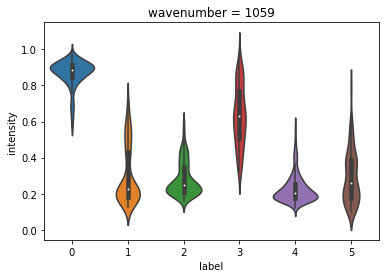

In [199]:
data_2 = pd.DataFrame(X)
data_2['label'] = np.array(y)

sns.violinplot(x='label',y=42,data=data_2)
plt.title('wavenumber = 1059')
plt.ylabel('intensity')
plt.show()

# ANN

In [351]:
# Define functional model
import tensorflow as tf
from tensorflow import keras

def mish(inputs):
    x = tf.nn.softplus(inputs)
    x = tf.nn.tanh(x)
    x = tf.multiply(x, inputs)
    return x

inputs = keras.Input(shape=342)
dense1 = keras.layers.Dense(128, activation=mish)
dense2 = keras.layers.Dense(64, activation=mish) #64
dense3 = keras.layers.Dense(32, activation=mish) #32
dense4 = keras.layers.Dense(6, activation='softmax',name='category_output')

x = dense1(inputs)
x = dense2(x)
x = dense3(x)
output = dense4(x)

ann = keras.Model(inputs=inputs, outputs=output, name='ANN')
ann.summary()

Model: "ANN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 342)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               43904     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
category_output (Dense)      (None, 6)                 198       
Total params: 54,438
Trainable params: 54,438
Non-trainable params: 0
_________________________________________________________________


In [352]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(lr=0.001) 
metrics = [keras.metrics.SparseCategoricalAccuracy()] #'accuaracy'

checkpoint_filepath = "/Users/alicetsai/Desktop/sustainable/Raman/Raman_楊博/checkpoint/ann_2.h5"

ann.compile(loss = loss, optimizers=optim, metrics = metrics)

In [53]:
X

0         1         2         3         4         5         6  \
36    0.069516  0.074434  0.081158  0.089689  0.100025  0.114703  0.120813   
37    0.196991  0.184912  0.172685  0.160310  0.147787  0.112750  0.100969   
38    0.166590  0.161840  0.157857  0.154640  0.152189  0.122342  0.119809   
39    0.082858  0.096488  0.104826  0.107871  0.105623  0.085493  0.073271   
40    0.084679  0.096658  0.106037  0.112817  0.116997  0.103736  0.108062   
...        ...       ...       ...       ...       ...       ...       ...   
1825  0.056770  0.070051  0.080172  0.087132  0.090930  0.084708  0.081043   
1826  0.019286  0.035161  0.047131  0.055197  0.059359  0.057313  0.049305   
1827  0.029667  0.056118  0.075530  0.087902  0.093235  0.086102  0.074839   
1828  0.016803  0.046780  0.068264  0.081258  0.085759  0.077437  0.061638   
1829  0.032130  0.041190  0.047435  0.050868  0.051487  0.046968  0.039100   

             7         8         9  ...       332       333       334  \
36    0.142977  0.159151  0.149605  ...  0.103165  0.093635  0.087520   
37    0.116653  0.118610  0.139467  ...  0.139500  0.131192  0.132603   
38    0.146224  0.165713  0.153700  ...  0.108208  0.109349  0.143370   
39    0.057297  0.068358  0.086803  ...  0.054719  0.061960  0.099811   
40    0.123389  0.124615  0.128576  ...  0.123234  0.127376  0.122594   
...        ...       ...       ...  ...       ...       ...       ...   
1825  0.068820  0.061493  0.072302  ...  0.026427  0.025752  0.029736   
1826  0.040499  0.032198  0.026117  ...  0.024673  0.025029  0.027636   
1827  0.061989  0.050714  0.043644  ...  0.026905  0.024185  0.025357   
1828  0.049677  0.041903  0.035895  ...  0.032314  0.031740  0.032629   
1829  0.032633  0.032484  0.032438  ...  0.043917  0.045000  0.045384   

           335       336       337       338       339       340       341  
36    0.094571  0.105211  0.129701  0.127878  0.119438  0.104380  0.082705  
37    0.130838  0.130886  0.124997  0.123915  0.124903  0.127959  0.133084  
38    0.166745  0.167781  0.163083  0.152811  0.137266  0.116446  0.090351  
39    0.141076  0.154749  0.162680  0.155958  0.134694  0.098887  0.048537  
40    0.122529  0.113174  0.111161  0.100791  0.084497  0.062280  0.034139  
...        ...       ...       ...       ...       ...       ...       ...  
1825  0.029793  0.032251  0.042093  0.042242  0.038827  0.031846  0.021299  
1826  0.030399  0.031362  0.028635  0.026143  0.023082  0.019452  0.015254  
1827  0.023513  0.022626  0.029301  0.030793  0.032016  0.032970  0.033657  
1828  0.036919  0.042444  0.042353  0.040852  0.038102  0.034103  0.028856  
1829  0.043006  0.039738  0.037410  0.036201  0.036026  0.036884  0.038776  

[1751 rows x 342 columns]

In [68]:
# training

from keras import backend as K

#data = pd.read_csv("./Raman_6_cls_3.csv",index_col=0)
#X = data
#X.drop([687],inplace=True)
#y = X['cls']
#X = data.drop(['label','folder_name','file_name','cls'],axis=1)
#print(X.shape)
#wavenumber = x
#X = np.array(X)

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42)
batch_size = 128 #128
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

epochs = 200
X_train =  K.cast_to_floatx(X_train)
y_train = K.cast_to_floatx(y_train)
X_val = K.cast_to_floatx(X_val)
y_val =  K.cast_to_floatx(y_val)
X_test = K.cast_to_floatx(X_test)
y_test =  K.cast_to_floatx(y_test)


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,monitor='val_acc',mode='max')
#model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,monitor='val_accuracy',mode='max',save_best_only=True,save_freq='epoch')

#ann.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(X_val,y_val),shuffle=True,verbose=2,callbacks=[model_checkpoint_callback])

(1400, 342)
(351, 342)
(294, 342)


In [353]:
print(y_test.shape)
pd.DataFrame(y_test).value_counts()
ann.load_weights("./checkpoint/ann_2.h5")

(294,)


In [354]:
history_dict = ann.history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss,label='Train')
plt.plot(epochs, val_loss,label='Val') 
plt.xlabel("epochs",fontsize=12)
plt.ylabel("loss",fontsize=12)
plt.legend()
plt.show()

train_acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
plt.plot(epochs, train_acc, label='Train')
plt.plot(epochs, val_acc,label='Val')
plt.xlabel("epochs",fontsize=12)
plt.ylabel("accuracy",fontsize=12)
plt.legend()
plt.show()


AttributeError: 'Model' object has no attribute 'history'

In [30]:
test = test_PS10.iloc[:,:-4]
test =  K.cast_to_floatx(test)
prediction = ann.predict(test)
for i in range(prediction.shape[0]):
    print("test_PS10")
    print(prediction[0].argmax())


test_PS10
4
test_PS10
4
test_PS10
4
test_PS10
4


(294, 342)
     
294


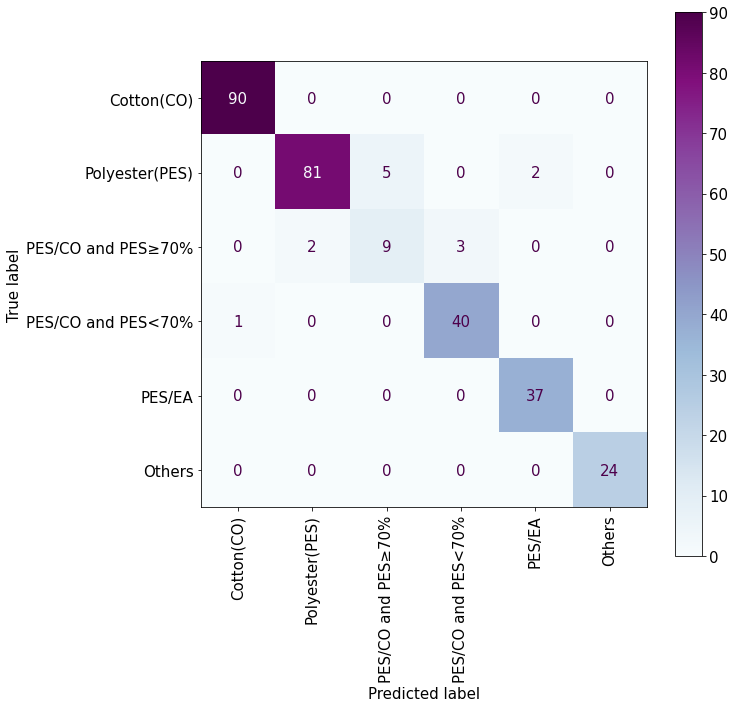

294/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.0934914691107613, 0.9557823]

In [357]:
print(X_test.shape)
pred = ann.predict(X_test)

print("     ")
pred = pd.DataFrame(pred)

prediction = []
for i in range(pred.shape[0]):
    prediction.append(pred.iloc[i].argmax())
    

print(len(prediction))

cm = confusion_matrix(y_test, np.array(prediction))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Cotton(CO)','Polyester(PES)','PES/CO and PES≥70%','PES/CO and PES<70%','PES/EA','Others'])
disp.plot(xticks_rotation='vertical',cmap='BuPu')

fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10) 
plt.rcParams.update({'font.size':22})
plt.show()

ann.evaluate(X_test,y_test)

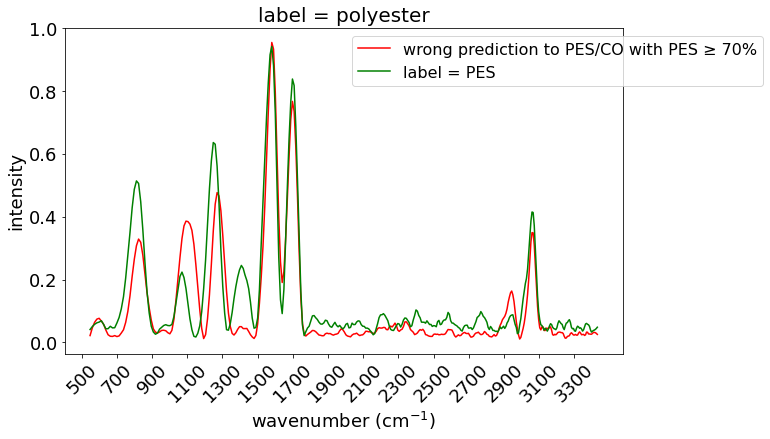

In [369]:
# 1. PES(1) was wrong classified to PES/CO with PES ≥ 70%(2). 

plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size':18})

plt.plot(wavenumber,test_data.iloc[34][:-4],label="wrong prediction to PES/CO with PES ≥ 70%",c='red')
plt.plot(wavenumber,test_data.iloc[85][:-4],label="label = PES",c='green')
plt.title('label = polyester',fontsize=20)
plt.xlabel("wavenumber (cm$^{−1}$)") #$^{n+1}$
plt.ylabel('intensity')

plt.xticks(np.arange(500, 3500, 200),rotation=45)
plt.legend(bbox_to_anchor=(0.5, 1.0),fontsize=16)
plt.show()


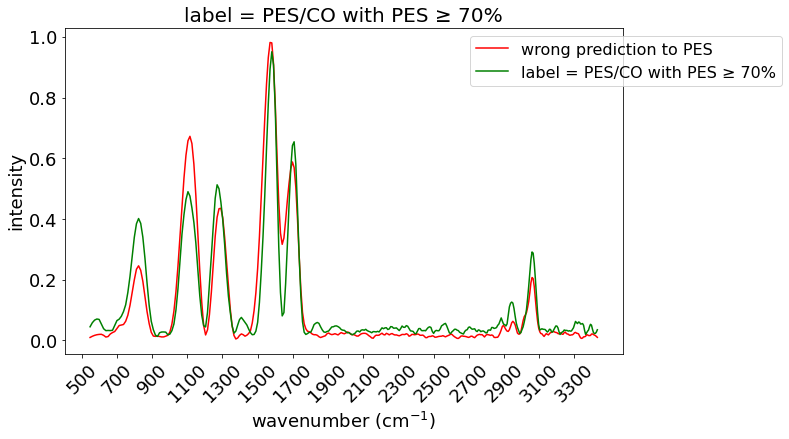

In [372]:
#2. PES/CO with PES ≥ 70%(2) was wrong classified to PES(1). 

plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size':18})

plt.plot(wavenumber,test_data.iloc[186][:-4],label="wrong prediction to PES",c='red')
plt.plot(wavenumber,test_data.iloc[178][:-4],label="label = PES/CO with PES ≥ 70%",c='green')
plt.title('label = PES/CO with PES ≥ 70%',fontsize=20)
plt.xlabel("wavenumber (cm$^{-1}$)")
plt.ylabel('intensity')
plt.xticks(np.arange(500, 3500, 200),rotation=45)
plt.legend(bbox_to_anchor=(1.3, 1.0),fontsize=16)
plt.show()

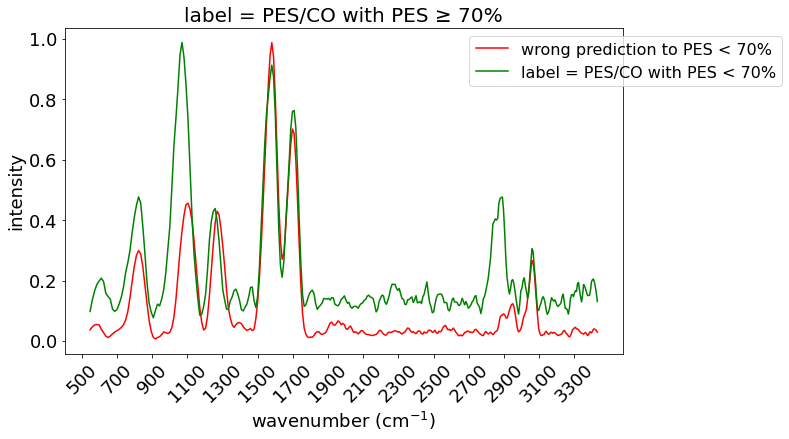

In [375]:
#3. PES/CO with PES ≥ 70%(2) was wrong classified to PES/CO with PES < 70% (3).
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size':18})

plt.plot(wavenumber,test_data.iloc[184][:-4],label="wrong prediction to PES < 70%",c='red')
plt.plot(wavenumber,test_data.iloc[194][:-4],label="label = PES/CO with PES < 70%",c='green')
plt.title('label = PES/CO with PES ≥ 70%',fontsize=20)
plt.xlabel("wavenumber (cm$^{-1}$)")
plt.ylabel('intensity')
plt.xticks(np.arange(500, 3500, 200),rotation=45)
plt.legend(bbox_to_anchor=(1.3, 1.0),fontsize=16)
plt.show()

In [372]:
result = pd.DataFrame([y_test,prediction])
result = result.transpose()
result.columns = ['gt', 'prediction']
result[result['gt']==3]


gt  prediction
192  3.0         3.0
193  3.0         3.0
194  3.0         3.0
195  3.0         3.0
196  3.0         3.0
197  3.0         3.0
198  3.0         3.0
199  3.0         3.0
200  3.0         3.0
201  3.0         3.0
202  3.0         3.0
203  3.0         3.0
204  3.0         3.0
205  3.0         3.0
206  3.0         3.0
207  3.0         3.0
208  3.0         3.0
209  3.0         3.0
210  3.0         3.0
211  3.0         3.0
212  3.0         3.0
213  3.0         3.0
214  3.0         3.0
215  3.0         3.0
216  3.0         3.0
217  3.0         3.0
218  3.0         3.0
219  3.0         3.0
220  3.0         3.0
221  3.0         3.0
222  3.0         3.0
223  3.0         3.0
224  3.0         0.0
225  3.0         3.0
226  3.0         3.0
227  3.0         3.0
228  3.0         3.0
229  3.0         3.0
230  3.0         3.0
231  3.0         3.0
232  3.0         3.0

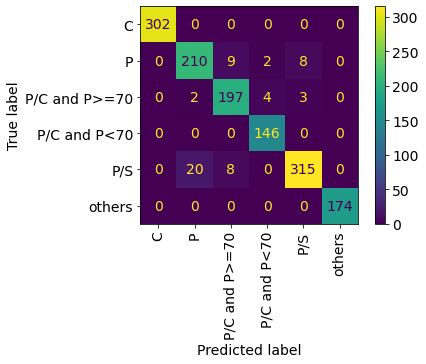

In [725]:
pred = ann.predict(X_train)

print("     ")
pred = pd.DataFrame(pred)

prediction = []
for i in range(pred.shape[0]):
    prediction.append(pred.iloc[i].argmax())


cm = confusion_matrix(y_train, np.array(prediction))
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['C100','P100','P>70','P<70','PS','others'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['C','P','P/C and P>=70','P/C and P<70','P/S','others'])
disp.plot(xticks_rotation='vertical')
plt.show()

In [727]:
ann.evaluate(X_val,y_val)

351/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.1171836370756143, 0.92877495]

In [ ]:
import shap
shap.initjs()

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# 使用 Deep SHAP 解釋模型
explainer = shap.KernelExplainer(ann, X_train.iloc[:50,:])
# 估計 Shapely values
shap_values = explainer.shap_values(X_test)

In [36]:
pd.DataFrame([y_test,pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3.

In [ ]:
shap.summary_plot(shap_values,X_test,feature_names=wavenumber,show=False, max_display=X_test.shape[1])

In [ ]:
shap.summary_plot(shap_values[4],X_test,feature_names=wavenumber,plot_type="violin")

In [ ]:
explainer = shap.KernelExplainer(ann.predict, X_train.iloc[:100,:])

In [ ]:
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values,X_test,feature_names=wavenumber)

In [ ]:
X_test = X_test.set_axis(np.round(wavenumber).tolist(),axis=1)

In [ ]:
shap.summary_plot(shap_values[1],X_test,feature_names=name,plot_type="violin", max_display=X.shape[1],sort=False)

In [ ]:
shap_values[0][50,:].shape
print(y_test[12])

shap.decision_plot(explainer.expected_value[1], shap_values[1][0,:], [str(x) for x in X_test.columns.to_list()])

In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values[0],feature_names=name)

In [ ]:
name = [str(x) for x in X_test.columns.to_list()]
shap.plots.force(explainer.expected_value[1], shap_values[1][0, :], X_test.iloc[0, :],matplotlib = True,feature_names=name)

In [ ]:
print(y_test[0])
plt.plot(wavenumber, X_test.iloc[0])
plt.show()

In [ ]:
name = [str(x) for x in X_test.columns.to_list()]
shap.plots.force(explainer.expected_value[1], shap_values[1][0, :], X_test.iloc[0, :],matplotlib = True,feature_names=name)

# CNN

In [728]:
import pandas as pd
import numpy as np
from keras.layers import InputLayer,Conv1D,MaxPooling1D,Dense,Dropout,Flatten
from keras.models import Sequential 
import keras
from keras.optimizers import Adam

In [729]:
X = np.array(X)
X = X.reshape(X.shape[0], X.shape[1], 1)
print(X.shape)

(1751, 342, 1)


In [730]:
X = np.array(X)
X = X.reshape(X.shape[0], X.shape[1], 1)
print(X.shape)
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42)

labels = ['C100','P100','P>70','P<70','PS','others']

(1751, 342, 1)


In [731]:
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [732]:
from keras import backend as K
batch_size = 32 #32

epochs = 200

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1400, 342, 1)
(351, 342, 1)
(294, 342, 1)


In [733]:
from keras.layers import InputLayer,Conv1D,MaxPooling1D,Dense,Dropout,Flatten
from keras.models import Sequential 
import keras

cnn = Sequential()
cnn.add(Conv1D(filters=32,kernel_size=5,activation='relu',input_shape=(342,1)))
cnn.add(MaxPooling1D(pool_size=4))
cnn.add(Conv1D(filters=64,kernel_size=5,activation='relu'))
cnn.add(MaxPooling1D(pool_size=4))
cnn.add(Conv1D(filters=128,kernel_size=5,activation='relu'))
cnn.add(MaxPooling1D(pool_size=4))
cnn.add(Flatten())
cnn.add(Dense(32,activation='relu'))
cnn.add(Dense(6,activation='softmax'))

cnn.name = "cnn"
cnn.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 338, 32)           192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 84, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 80, 64)            10304     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 16, 128)           41088     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 4, 128)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0       

In [734]:
from tensorflow.keras import optimizers
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = optimizers.Adam(lr=0.001)
metrics = [keras.metrics.SparseCategoricalAccuracy()] #'accuaracy'

checkpoint_filepath ="/Users/alicetsai/Desktop/sustainable/Raman/Raman_楊博/checkpoint/cnn_2.h5"

cnn.compile(loss = loss, optimizer=optim, metrics = metrics)

In [735]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,monitor='val_acc',mode='max')
    
cnn.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(X_val,y_val),shuffle=True,verbose=2,callbacks=[model_checkpoint_callback])

Train on 1400 samples, validate on 351 samples
Epoch 1/200
 - 2s - loss: 1.6103 - sparse_categorical_accuracy: 0.4871 - val_loss: 1.4735 - val_sparse_categorical_accuracy: 0.5641
Epoch 2/200
 - 1s - loss: 1.4795 - sparse_categorical_accuracy: 0.5571 - val_loss: 1.4786 - val_sparse_categorical_accuracy: 0.5641
Epoch 3/200
 - 1s - loss: 1.4738 - sparse_categorical_accuracy: 0.5693 - val_loss: 1.4717 - val_sparse_categorical_accuracy: 0.5670
Epoch 4/200
 - 1s - loss: 1.4679 - sparse_categorical_accuracy: 0.5736 - val_loss: 1.4778 - val_sparse_categorical_accuracy: 0.5613
Epoch 5/200
 - 1s - loss: 1.4688 - sparse_categorical_accuracy: 0.5729 - val_loss: 1.4602 - val_sparse_categorical_accuracy: 0.5812
Epoch 6/200
 - 1s - loss: 1.4621 - sparse_categorical_accuracy: 0.5800 - val_loss: 1.4599 - val_sparse_categorical_accuracy: 0.5840
Epoch 7/200
 - 1s - loss: 1.4497 - sparse_categorical_accuracy: 0.5936 - val_loss: 1.4268 - val_sparse_categorical_accuracy: 0.6211
Epoch 8/200
 - 1s - loss: 1.3

Epoch 63/200
 - 1s - loss: 1.1294 - sparse_categorical_accuracy: 0.9150 - val_loss: 1.1475 - val_sparse_categorical_accuracy: 0.8946
Epoch 64/200
 - 1s - loss: 1.1237 - sparse_categorical_accuracy: 0.9250 - val_loss: 1.1387 - val_sparse_categorical_accuracy: 0.9031
Epoch 65/200
 - 1s - loss: 1.1081 - sparse_categorical_accuracy: 0.9364 - val_loss: 1.1221 - val_sparse_categorical_accuracy: 0.9202
Epoch 66/200
 - 1s - loss: 1.1000 - sparse_categorical_accuracy: 0.9464 - val_loss: 1.1319 - val_sparse_categorical_accuracy: 0.9088
Epoch 67/200
 - 1s - loss: 1.1132 - sparse_categorical_accuracy: 0.9314 - val_loss: 1.1325 - val_sparse_categorical_accuracy: 0.9145
Epoch 68/200
 - 1s - loss: 1.1011 - sparse_categorical_accuracy: 0.9429 - val_loss: 1.1343 - val_sparse_categorical_accuracy: 0.9117
Epoch 69/200
 - 1s - loss: 1.1035 - sparse_categorical_accuracy: 0.9386 - val_loss: 1.1348 - val_sparse_categorical_accuracy: 0.9060
Epoch 70/200
 - 1s - loss: 1.0918 - sparse_categorical_accuracy: 0.95

Epoch 125/200
 - 1s - loss: 1.0594 - sparse_categorical_accuracy: 0.9850 - val_loss: 1.0816 - val_sparse_categorical_accuracy: 0.9601
Epoch 126/200
 - 1s - loss: 1.0578 - sparse_categorical_accuracy: 0.9871 - val_loss: 1.0806 - val_sparse_categorical_accuracy: 0.9630
Epoch 127/200
 - 1s - loss: 1.0639 - sparse_categorical_accuracy: 0.9807 - val_loss: 1.0842 - val_sparse_categorical_accuracy: 0.9573
Epoch 128/200
 - 1s - loss: 1.0580 - sparse_categorical_accuracy: 0.9850 - val_loss: 1.0713 - val_sparse_categorical_accuracy: 0.9715
Epoch 129/200
 - 1s - loss: 1.0563 - sparse_categorical_accuracy: 0.9886 - val_loss: 1.0741 - val_sparse_categorical_accuracy: 0.9715
Epoch 130/200
 - 1s - loss: 1.0518 - sparse_categorical_accuracy: 0.9929 - val_loss: 1.0756 - val_sparse_categorical_accuracy: 0.9687
Epoch 131/200
 - 1s - loss: 1.0498 - sparse_categorical_accuracy: 0.9950 - val_loss: 1.0661 - val_sparse_categorical_accuracy: 0.9801
Epoch 132/200
 - 1s - loss: 1.0540 - sparse_categorical_accura

Epoch 187/200
 - 1s - loss: 1.0472 - sparse_categorical_accuracy: 0.9964 - val_loss: 1.0641 - val_sparse_categorical_accuracy: 0.9801
Epoch 188/200
 - 1s - loss: 1.0472 - sparse_categorical_accuracy: 0.9964 - val_loss: 1.0677 - val_sparse_categorical_accuracy: 0.9744
Epoch 189/200
 - 1s - loss: 1.0478 - sparse_categorical_accuracy: 0.9964 - val_loss: 1.0672 - val_sparse_categorical_accuracy: 0.9744
Epoch 190/200
 - 1s - loss: 1.0484 - sparse_categorical_accuracy: 0.9957 - val_loss: 1.0676 - val_sparse_categorical_accuracy: 0.9772
Epoch 191/200
 - 1s - loss: 1.0482 - sparse_categorical_accuracy: 0.9964 - val_loss: 1.0639 - val_sparse_categorical_accuracy: 0.9801
Epoch 192/200
 - 1s - loss: 1.0486 - sparse_categorical_accuracy: 0.9943 - val_loss: 1.0695 - val_sparse_categorical_accuracy: 0.9744
Epoch 193/200
 - 1s - loss: 1.0493 - sparse_categorical_accuracy: 0.9943 - val_loss: 1.0622 - val_sparse_categorical_accuracy: 0.9801
Epoch 194/200
 - 1s - loss: 1.0501 - sparse_categorical_accura

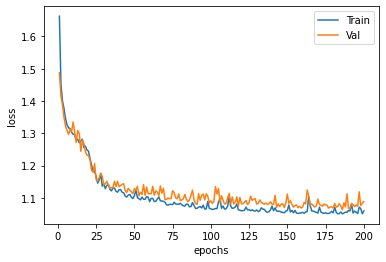

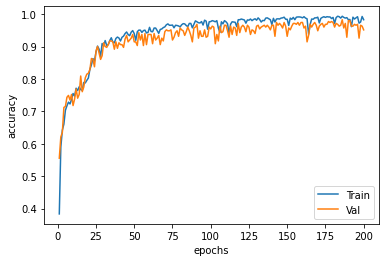

In [112]:
history_dict = cnn.history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss,label='Train')
plt.plot(epochs, val_loss,label='Val') 
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

train_acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
plt.plot(epochs, train_acc, label='Train')
plt.plot(epochs, val_acc,label='Val')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

(294, 342, 1)
     
294


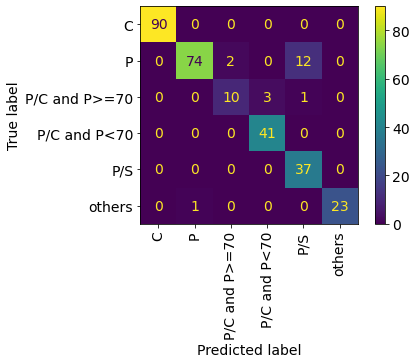

294/294 [==============================] - 0s 282us/step


[1.1058471535338836, 0.9353741407394409]

In [736]:
pred = cnn.predict(X_test)
print(X_test.shape)
print("     ")
pred = pd.DataFrame(pred)
prediction = []
for i in range(pred.shape[0]):
    prediction.append(pred.iloc[i].argmax())

print(len(prediction))
cm = confusion_matrix(y_test, np.array(prediction))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['C','P','P/C and P>=70','P/C and P<70','P/S','others'])
disp.plot(xticks_rotation='vertical')
plt.show()

cnn.evaluate(X_test,y_test)

In [738]:
cnn.evaluate(X_val,y_val)

351/351 [==============================] - 0s 274us/step


[1.066364149762015, 0.9772079586982727]

In [702]:
cnn = tf.keras.models.load_model("./checkpoint/cnn.h5")

In [ ]:
from sklearn.metrics import average_precision_score, precision_recall_curve

# For each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(6):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], precision[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], precision[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test.ravel(), precision.ravel()
)
average_precision["micro"] = average_precision_score(y_test, precision, average="micro")



In [ ]:
import numpy as np
from keras.models import Model
from grad_cam import grad_cam

data_vector = np.expand_dims(X_test[0], axis=0)
pred = cnn.predict(data_vector)
print(pred)
category_index = np.argmax(pred)
print(category_index)
for layer in cnn.layers:
    if 'conv1d' in layer.name:
        conv_name = layer.name
        print(conv_name)

nb_classes = 6
heatmap = grad_cam(cnn, data_vector, category_index, conv_name, nb_classes)
print("predicted:",labels[category_index])
print("gt:",labels[y_test.iloc[0]])

print(heatmap.shape)
print(wavenumber.shape)
plt.plot(wavenumber,heatmap,label='heatmap')

result = np.expand_dims(heatmap, axis=1)*X_test[i]
min_max_scaler = MinMaxScaler()
norm_result = min_max_scaler.fit_transform(result)

plt.plot(wavenumber,X_test[0],label='spectrum')
plt.plot(wavenumber,norm_result,label='heatmap*spectrum')
plt.legend()
plt.show()





In [ ]:
wavenumber[341]

In [ ]:
for i in range(100):
    if y_test.iloc[i]==0:
        data_vector = np.expand_dims(X_test[i], axis=0)
        pred = cnn.predict(data_vector)
        category_index = np.argmax(pred)
        for layer in cnn.layers:
            if 'conv1d' in layer.name:
                conv_name = layer.name
        nb_classes = 6
        heatmap = grad_cam(cnn, data_vector, category_index,  conv_name, nb_classes)
        print("predicted:",labels[category_index])
        print("gt:",labels[y_test.iloc[i]])
        #plt.plot(wavenumber,heatmap, label='heatmap')
        plt.plot(wavenumber,X_test[i],label='spectrum')
        min_max_scaler = MinMaxScaler()
        result = np.expand_dims(heatmap, axis=1)*X_test[i]
        norm_result = min_max_scaler.fit_transform(result)
        
        x = wavenumber
        extent = [x[0]+250-(x[1]-x[0])/2., x[-1]+250+(x[1]-x[0])/2.,0,1]
        plt.imshow(heatmap[np.newaxis,:],cmap="magma", aspect="auto",extent=extent)
        
        #plt.plot(wavenumber,norm_result,label='heatmap*spectrum')
        plt.legend()
        plt.show()

In [ ]:
for i in range(100):
    if y_test.iloc[i]==1:
        data_vector = np.expand_dims(X_test[i], axis=0)
        pred = cnn.predict(data_vector)
        category_index = np.argmax(pred)
        for layer in cnn.layers:
            if 'conv1d' in layer.name:
                conv_name = layer.name
        nb_classes = 6
        heatmap = grad_cam(cnn, data_vector, category_index, conv_name, nb_classes)
        print("predicted:",labels[category_index])
        print("gt:",labels[y_test.iloc[i]])
        #plt.plot(wavenumber,heatmap, label='heatmap')
        plt.plot(wavenumber,X_test[i],label='spectrum')
        min_max_scaler = MinMaxScaler()
        result = np.expand_dims(heatmap, axis=1)*X_test[i]
        norm_result = min_max_scaler.fit_transform(result)
        
        x = wavenumber
        extent = [x[0]+250-(x[1]-x[0])/2., x[-1]+250+(x[1]-x[0])/2.,0,1]
        plt.imshow(heatmap[np.newaxis,:],cmap="magma", aspect="auto",extent=extent)
        
        #plt.plot(wavenumber,norm_result,label='heatmap*spectrum')
        plt.legend()
        plt.show()

In [ ]:
for i in range(100):
    if y_test.iloc[i]==3:
        data_vector = np.expand_dims(X_test[i], axis=0)
        pred = cnn.predict(data_vector)
        category_index = np.argmax(pred)
        for layer in cnn.layers:
            if 'conv1d' in layer.name:
                conv_name = layer.name
        nb_classes = 6
        heatmap = grad_cam(cnn, data_vector, category_index, conv_name, nb_classes)
        print("predicted:",labels[category_index])
        print("gt:",labels[y_test.iloc[i]])
        #plt.plot(wavenumber,heatmap, label='heatmap')
        plt.plot(wavenumber,X_train[i],label='spectrum')
        min_max_scaler = MinMaxScaler()
        result = np.expand_dims(heatmap, axis=1)*X_test[i]
        norm_result = min_max_scaler.fit_transform(result)
        
        x = wavenumber
        extent = [x[0]+250-(x[1]-x[0])/2., x[-1]+250+(x[1]-x[0])/2.,0,1]
        plt.imshow(heatmap[np.newaxis,:],cmap="magma", aspect="auto",extent=extent)
        
        #plt.plot(wavenumber,norm_result,label='heatmap*spectrum')
        plt.legend()
        plt.show()

In [ ]:
for i in range(200):
    if y_test.iloc[i]==4:
        data_vector = np.expand_dims(X_test[i], axis=0)
        pred = cnn.predict(data_vector)
        category_index = np.argmax(pred)
        for layer in cnn.layers:
            if 'conv1d' in layer.name:
                conv_name = layer.name
        nb_classes = 6
        heatmap = grad_cam(cnn, data_vector, category_index, conv_name, nb_classes)
        print("predicted:",labels[category_index])
        print("gt:",labels[y_test.iloc[i]])
        #plt.plot(wavenumber,heatmap, label='heatmap')
        plt.plot(wavenumber,X_train[i],label='spectrum')
        min_max_scaler = MinMaxScaler()
        result = np.expand_dims(heatmap, axis=1)*X_test[i]
        norm_result = min_max_scaler.fit_transform(result)
        
        x = wavenumber
        extent = [x[0]+250-(x[1]-x[0])/2., x[-1]+250+(x[1]-x[0])/2.,0,1]
        plt.imshow(heatmap[np.newaxis,:],cmap="magma", aspect="auto",extent=extent)
        
        #plt.plot(wavenumber,norm_result,label='heatmap*spectrum')
        plt.legend()
        plt.show()

In [ ]:
for i in range(100):
    if y_test.iloc[i]==5:
        data_vector = np.expand_dims(X_test[i], axis=0)
        pred = cnn.predict(data_vector)
        category_index = np.argmax(pred)
        for layer in cnn.layers:
            if 'conv1d' in layer.name:
                conv_name = layer.name
        nb_classes = 6
        heatmap = grad_cam(cnn, data_vector, category_index, conv_name, nb_classes)
        print("predicted:",labels[category_index])
        print("gt:",labels[y_test.iloc[i]])
        #plt.plot(wavenumber,heatmap, label='heatmap')
        plt.plot(wavenumber,X_train[i],label='spectrum')
        min_max_scaler = MinMaxScaler()
        result = np.expand_dims(heatmap, axis=1)*X_test[i]
        norm_result = min_max_scaler.fit_transform(result)
        
        x = wavenumber
        extent = [x[0]+250-(x[1]-x[0])/2., x[-1]+250+(x[1]-x[0])/2.,0,1]
        plt.imshow(heatmap[np.newaxis,:],cmap="magma", aspect="auto",extent=extent)
        
        #plt.plot(wavenumber,norm_result,label='heatmap*spectrum')
        plt.legend()
        plt.show()

In [ ]:
last_conv_layer = cnn.get_layer('conv1d_6')
last_conv_layer.output[0]

In [ ]:
grads = K.gradients(output, last_conv_layer.output)[0]
print(grads.shape)

In [ ]:
x = np.expand_dims(X_test[0], axis=0)
print(x.shape)

In [ ]:
pooled_grads = K.mean(grads, axis=(0, 1))
iterate = K.function([cnn.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

In [ ]:
print(pooled_grads_value.shape)
print(conv_layer_output_value.shape)

# SHAP

In [ ]:
import shap
import xgboost
import seaborn as sns
import matplotlib.pyplot as plt

shap.initjs()

data = pd.read_csv("./abalone.data", 
                  names = ['sex','length','diameter','height',
                          'whole weight','shucked weight',
                          'viscera weight','shell weight',
                          'rings'])

In [ ]:
#Plot 1 : whole weight
plt.scatter(data['whole weight'],data['rings'])
plt.ylabel("rings",size=20)
plt.xlabel("whole weight", size=20)

In [ ]:
# Plot 3 : Correlation heatmap
cont = ["length","diameter","height",
       "whole weight","shucked weight",
       "viscera weight","shell weight",
       "rings"]
corr_matrix = pd.DataFrame(data[cont],columns=cont).corr()

sns.heatmap(corr_matrix,
           cmap="coolwarm",
           annot=True,
           fmt='.1g')

In [ ]:
#Plot 2 : whole weight
plt.boxplot(data[data.sex=="I"]['rings'], positions=[1],labels='I')
plt.boxplot(data[data.sex=="M"]['rings'], positions=[2],labels='M')
plt.boxplot(data[data.sex=="F"]['rings'], positions=[3],labels='F')

plt.xlabel("sex")
plt.ylabel("rings")

# Feature Engineering

In [ ]:
y = data['rings']
X = data[['sex','length','height',
         'shucked weight','viscera weight','shell weight']]

In [ ]:
# Create dummy variables
X['sex.M'] = [1 if s == 'M' else 0 for s in X['sex']]
X['sex.F'] = [1 if s == 'F' else 0 for s in X['sex']]
X['sex.I'] = [1 if s == 'I' else 0 for s in X['sex']]
X = X.drop('sex',axis=1)

X.head()

# Modeling

In [ ]:
# Train model
model = xgboost.XGBRegressor(objective="reg:squarederror")
model.fit(X,y)

In [ ]:
# Get predictions
y_pred = model.predict(X)

# Model evaluate
plt.figure(figsize=(5,5))

plt.scatter(y,y_pred)
plt.plot([0,30],[0,30],color='r',linestyle='-',linewidth=2)
plt.ylabel("Predicted",size=20)
plt.xlabel("Actual",size=20)

In [ ]:
print(np.mean(y_pred))
print(y_pred[0])

# 1) Standard SHAP values

In [ ]:
# Get shap values
explainer = shap.Explainer(model) 
shap_values = explainer(X) 

In [ ]:
np.shape(shap_values.values)

# Waterfall plot

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.plots.waterfall(shap_values[1],max_display=4)

In [ ]:
shap.plots.force(shap_values[0])

# Stacked force plot

In [ ]:
shap.plots.force(shap_values[0:100])

# Absolute Mean SHAP

In [ ]:
shap.plots.bar(shap_values)

# Beeswarm plot

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.violin(shap_values.values)

In [ ]:
#Plot 1 : shell weights
shap.plots.scatter(shap_values[:,"shell weight"])

In [ ]:
#Plot 2 : shucked weights
shap.plots.scatter(shap_values[:,"shucked weight"])

# Dependence Plots

In [ ]:
shap.plots.scatter(shap_values[:,"shell weight"],
                  color=shap_values[:,"shucked weight"])